In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/u/0/uc?id=1MaFmKMfEXPr9yuFGu_Ff9wV-3SlmC3Nz&export=download"
output = "data_2048.zip"
gdown.download(url, output)
!unzip data_2048.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1MaFmKMfEXPr9yuFGu_Ff9wV-3SlmC3Nz&export=download
From (redirected): https://drive.google.com/uc?id=1MaFmKMfEXPr9yuFGu_Ff9wV-3SlmC3Nz&export=download&confirm=t&uuid=6a23ed6c-54bb-4ee8-a72f-fef6ad3aad68
To: /content/data_2048.zip
100%|██████████| 217M/217M [00:02<00:00, 106MB/s] 


Output streaming troncato alle ultime 5000 righe.
  inflating: data_2048/clean/images/1_1695.png  
  inflating: data_2048/clean/images/1_1696.png  
  inflating: data_2048/clean/images/1_1697.png  
  inflating: data_2048/clean/images/1_1710.png  
  inflating: data_2048/clean/images/1_1711.png  
  inflating: data_2048/clean/images/1_1712.png  
  inflating: data_2048/clean/images/1_1714.png  
  inflating: data_2048/clean/images/1_1715.png  
  inflating: data_2048/clean/images/1_1716.png  
  inflating: data_2048/clean/images/1_1719.png  
  inflating: data_2048/clean/images/1_1723.png  
  inflating: data_2048/clean/images/1_1724.png  
  inflating: data_2048/clean/images/1_1726.png  
  inflating: data_2048/clean/images/1_1727.png  
  inflating: data_2048/clean/images/1_1728.png  
  inflating: data_2048/clean/images/1_1737.png  
  inflating: data_2048/clean/images/1_1741.png  
  inflating: data_2048/clean/images/1_1744.png  
  inflating: data_2048/clean/images/1_1745.png  
  inflating: data_2

In [4]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_2048")):
  print(folder)
  for im in tqdm(os.listdir("data_2048/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:35<01:47, 35.94s/it]

jammed_channel



 50%|█████     | 2/4 [00:39<00:33, 16.94s/it]

test



 75%|███████▌  | 3/4 [00:44<00:11, 11.24s/it]

clean_validation



100%|██████████| 4/4 [00:47<00:00, 11.78s/it]


In [5]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [6]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



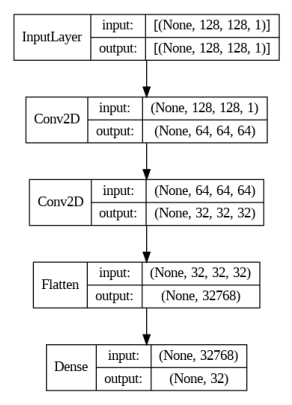

Summary of the decoder:



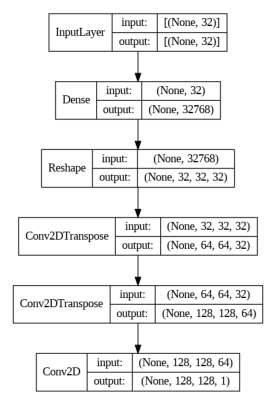

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [8]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 26s 60ms/step - loss: 0.0557 - val_loss: 0.0461
Epoch 2/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0459 - val_loss: 0.0455
Epoch 3/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0436 - val_loss: 0.0391
Epoch 4/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0362 - val_loss: 0.0348
Epoch 5/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0349 - val_loss: 0.0344
Epoch 6/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0347 - val_loss: 0.0343
Epoch 7/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0346 - val_loss: 0.0342
Epoch 8/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0345 - val_loss: 0.0341
Epoch 9/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0345 - val_loss: 0.0341
Epoch 10/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0344 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

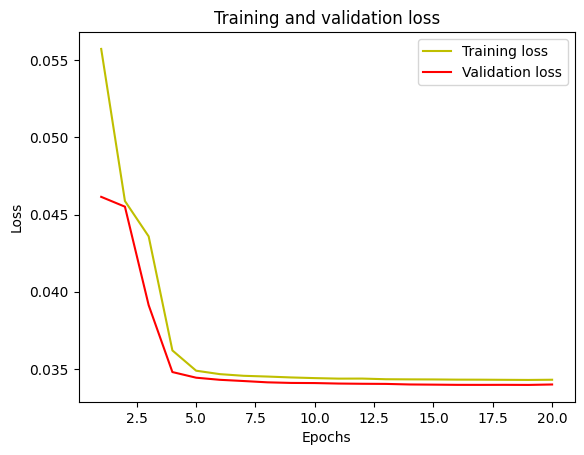

In [9]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 20ms/step


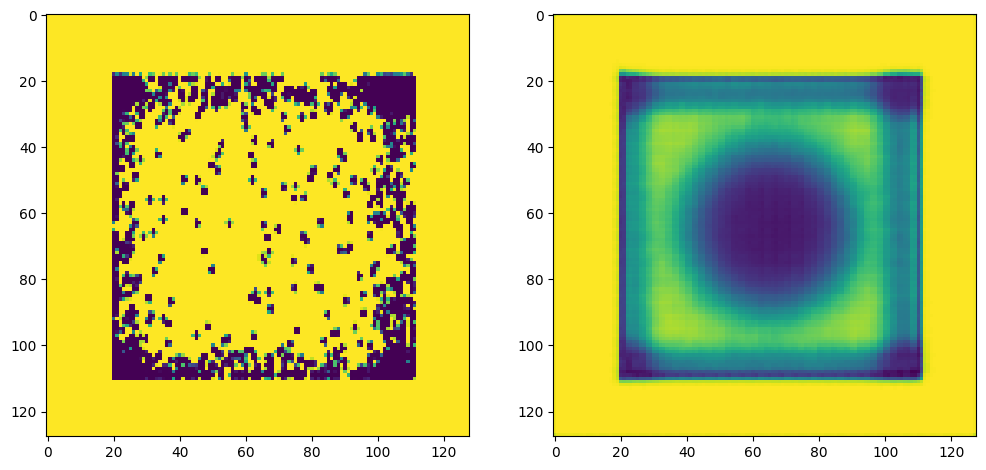

In [11]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [12]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 51ms/step - loss: 0.0632
Validation error 0.033999472856521606
Anomaly error 0.0631628930568695
The reconstruction error of the jammed channel is  1.8577609518658735  more than the clean channel


In [13]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [14]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 259ms/step - loss: 0.0352


  0%|          | 1/600 [00:00<03:32,  2.82it/s]

1/1 [==============================] - 0s 164ms/step - loss: 0.0362


  0%|          | 2/600 [00:00<03:02,  3.28it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0351


  0%|          | 3/600 [00:00<02:11,  4.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0367


  1%|          | 4/600 [00:00<01:54,  5.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0345


  1%|          | 5/600 [00:01<01:53,  5.25it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0347


  1%|          | 6/600 [00:01<01:39,  5.97it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0311


  1%|          | 7/600 [00:01<01:30,  6.59it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0342


  1%|▏         | 8/600 [00:01<01:28,  6.65it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0353


  2%|▏         | 9/600 [00:01<01:32,  6.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0324


  2%|▏         | 10/600 [00:01<01:32,  6.39it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0345


  2%|▏         | 11/600 [00:01<01:32,  6.35it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0344


  2%|▏         | 12/600 [00:02<01:27,  6.68it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0310


  2%|▏         | 13/600 [00:02<01:29,  6.53it/s]

1/1 [==============================] - 0s 67ms/step - loss: 0.0358


  2%|▏         | 14/600 [00:02<01:35,  6.13it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0326


  2%|▎         | 15/600 [00:02<01:33,  6.26it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0283


  3%|▎         | 16/600 [00:02<01:31,  6.36it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0312


  3%|▎         | 17/600 [00:02<01:31,  6.40it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0349


  3%|▎         | 18/600 [00:03<01:31,  6.39it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0345


  3%|▎         | 19/600 [00:03<01:24,  6.84it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0360


  3%|▎         | 20/600 [00:03<01:18,  7.42it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0354


  4%|▎         | 21/600 [00:03<01:17,  7.49it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0366


  4%|▎         | 22/600 [00:03<01:26,  6.67it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0339


  4%|▍         | 23/600 [00:03<01:20,  7.20it/s]

1/1 [==============================] - 0s 68ms/step - loss: 0.0361


  4%|▍         | 24/600 [00:03<01:20,  7.16it/s]

1/1 [==============================] - 0s 110ms/step - loss: 0.0367


  4%|▍         | 25/600 [00:04<01:45,  5.44it/s]

1/1 [==============================] - 0s 91ms/step - loss: 0.0310


  4%|▍         | 26/600 [00:04<01:55,  4.97it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0352


  4%|▍         | 27/600 [00:04<01:39,  5.75it/s]

1/1 [==============================] - 0s 93ms/step - loss: 0.0297


  5%|▍         | 28/600 [00:04<01:44,  5.49it/s]

1/1 [==============================] - 0s 85ms/step - loss: 0.0306


  5%|▍         | 29/600 [00:04<01:48,  5.28it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0339


  5%|▌         | 30/600 [00:05<01:40,  5.69it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0348


  5%|▌         | 31/600 [00:05<01:37,  5.81it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0357


  5%|▌         | 32/600 [00:05<01:31,  6.20it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0354


  6%|▌         | 33/600 [00:05<01:29,  6.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0303


  6%|▌         | 35/600 [00:05<01:09,  8.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0313


  6%|▌         | 37/600 [00:05<00:58,  9.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0349


  6%|▋         | 39/600 [00:06<00:57,  9.81it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0373


  7%|▋         | 41/600 [00:06<00:56,  9.92it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0303


  7%|▋         | 42/600 [00:06<00:58,  9.59it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0278


  7%|▋         | 43/600 [00:06<00:59,  9.44it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0344


  7%|▋         | 44/600 [00:06<00:59,  9.37it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0345


  8%|▊         | 45/600 [00:06<00:59,  9.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0354


  8%|▊         | 46/600 [00:06<00:59,  9.34it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0355


  8%|▊         | 48/600 [00:06<00:57,  9.60it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0357


  8%|▊         | 49/600 [00:07<00:58,  9.36it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0322


  8%|▊         | 50/600 [00:07<01:01,  8.92it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0355


  8%|▊         | 51/600 [00:07<01:01,  8.91it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0394


  9%|▊         | 52/600 [00:07<01:01,  8.90it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0304


  9%|▉         | 54/600 [00:07<00:59,  9.14it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0344


  9%|▉         | 55/600 [00:07<01:00,  9.01it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0342


  9%|▉         | 56/600 [00:07<01:00,  9.06it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0291


 10%|▉         | 57/600 [00:07<00:59,  9.11it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0356


 10%|▉         | 58/600 [00:08<01:00,  9.01it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0310


 10%|▉         | 59/600 [00:08<00:59,  9.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0333


 10%|█         | 60/600 [00:08<00:58,  9.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0353


 10%|█         | 62/600 [00:08<00:53, 10.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 11%|█         | 64/600 [00:08<00:46, 11.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0347


 11%|█         | 66/600 [00:08<00:43, 12.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0357


 11%|█▏        | 68/600 [00:08<00:42, 12.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0355


 12%|█▏        | 70/600 [00:09<00:41, 12.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0367


 12%|█▏        | 72/600 [00:09<00:40, 12.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0338


 12%|█▏        | 74/600 [00:09<00:39, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0325


 13%|█▎        | 76/600 [00:09<00:39, 13.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0364


 13%|█▎        | 78/600 [00:09<00:38, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0333


 13%|█▎        | 80/600 [00:09<00:38, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0360


 14%|█▎        | 82/600 [00:09<00:38, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0314


 14%|█▍        | 84/600 [00:10<00:38, 13.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0381


 14%|█▍        | 86/600 [00:10<00:37, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0325


 15%|█▍        | 88/600 [00:10<00:37, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0352


 15%|█▌        | 90/600 [00:10<00:38, 13.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0353


 15%|█▌        | 92/600 [00:10<00:37, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0319


 16%|█▌        | 94/600 [00:10<00:38, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0337


 16%|█▌        | 96/600 [00:10<00:37, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0361


 16%|█▋        | 98/600 [00:11<00:36, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0336


 17%|█▋        | 100/600 [00:11<00:36, 13.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0338


 17%|█▋        | 102/600 [00:11<00:36, 13.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0372


 17%|█▋        | 104/600 [00:11<00:36, 13.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0386


 18%|█▊        | 106/600 [00:11<00:35, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0358


 18%|█▊        | 108/600 [00:11<00:36, 13.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0357


 18%|█▊        | 110/600 [00:11<00:35, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0352


 19%|█▊        | 112/600 [00:12<00:35, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0352


 19%|█▉        | 114/600 [00:12<00:35, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0344


 19%|█▉        | 116/600 [00:12<00:36, 13.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0282


 20%|█▉        | 118/600 [00:12<00:35, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0399


 20%|██        | 120/600 [00:12<00:35, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 20%|██        | 122/600 [00:12<00:34, 13.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0364


 21%|██        | 124/600 [00:13<00:35, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


 21%|██        | 126/600 [00:13<00:35, 13.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0359


 21%|██▏       | 128/600 [00:13<00:35, 13.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0338


 22%|██▏       | 130/600 [00:13<00:35, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0321


 22%|██▏       | 132/600 [00:13<00:34, 13.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0329


 22%|██▏       | 134/600 [00:13<00:35, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0306


 23%|██▎       | 136/600 [00:13<00:35, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0367


 23%|██▎       | 138/600 [00:14<00:35, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0357


 23%|██▎       | 140/600 [00:14<00:34, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0301


 24%|██▎       | 142/600 [00:14<00:33, 13.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0354


 24%|██▍       | 144/600 [00:14<00:32, 14.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0346


 24%|██▍       | 146/600 [00:14<00:33, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0350


 25%|██▍       | 148/600 [00:14<00:33, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0350


 25%|██▌       | 150/600 [00:14<00:32, 13.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0357


 25%|██▌       | 152/600 [00:15<00:33, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0288


 26%|██▌       | 154/600 [00:15<00:31, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0350


 26%|██▌       | 156/600 [00:15<00:31, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0312


 26%|██▋       | 158/600 [00:15<00:32, 13.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0323


 27%|██▋       | 160/600 [00:15<00:32, 13.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0368


 27%|██▋       | 162/600 [00:15<00:32, 13.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0317


 27%|██▋       | 164/600 [00:16<00:32, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0345


 28%|██▊       | 166/600 [00:16<00:31, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0346


 28%|██▊       | 168/600 [00:16<00:30, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0367


 28%|██▊       | 170/600 [00:16<00:30, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0337


 29%|██▊       | 172/600 [00:16<00:30, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0322


 29%|██▉       | 174/600 [00:16<00:31, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0352


 29%|██▉       | 176/600 [00:16<00:31, 13.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0321


 30%|██▉       | 178/600 [00:17<00:30, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0347


 30%|███       | 180/600 [00:17<00:30, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0343


 30%|███       | 182/600 [00:17<00:30, 13.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0355


 31%|███       | 184/600 [00:17<00:30, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0331


 31%|███       | 186/600 [00:17<00:29, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0327


 31%|███▏      | 188/600 [00:17<00:29, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0353


 32%|███▏      | 190/600 [00:17<00:30, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0350


 32%|███▏      | 192/600 [00:18<00:30, 13.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0354


 32%|███▏      | 194/600 [00:18<00:29, 13.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0365


 33%|███▎      | 196/600 [00:18<00:30, 13.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0341


 33%|███▎      | 198/600 [00:18<00:29, 13.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0324


 33%|███▎      | 200/600 [00:18<00:32, 12.34it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0281


 34%|███▎      | 202/600 [00:18<00:36, 11.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0339


 34%|███▍      | 204/600 [00:19<00:36, 10.83it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0326


 34%|███▍      | 206/600 [00:19<00:36, 10.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0345


 35%|███▍      | 208/600 [00:19<00:36, 10.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0306


 35%|███▌      | 210/600 [00:19<00:36, 10.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0375


 35%|███▌      | 212/600 [00:19<00:36, 10.51it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0350


 36%|███▌      | 214/600 [00:20<00:39,  9.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0375


 36%|███▌      | 216/600 [00:20<00:38,  9.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0343


 36%|███▌      | 217/600 [00:20<00:39,  9.82it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0360


 36%|███▋      | 218/600 [00:20<00:39,  9.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0365


 36%|███▋      | 219/600 [00:20<00:40,  9.52it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0350


 37%|███▋      | 220/600 [00:20<00:40,  9.44it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0365


 37%|███▋      | 221/600 [00:20<00:44,  8.55it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0375


 37%|███▋      | 222/600 [00:20<00:44,  8.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0347


 37%|███▋      | 223/600 [00:21<00:42,  8.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0280


 38%|███▊      | 225/600 [00:21<00:36, 10.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0272


 38%|███▊      | 227/600 [00:21<00:32, 11.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0332


 38%|███▊      | 229/600 [00:21<00:30, 12.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0335


 38%|███▊      | 231/600 [00:21<00:30, 12.28it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0358


 39%|███▉      | 233/600 [00:21<00:31, 11.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0323


 39%|███▉      | 235/600 [00:22<00:44,  8.28it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0355


 39%|███▉      | 236/600 [00:22<00:47,  7.69it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0317


 40%|███▉      | 237/600 [00:22<00:49,  7.33it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0374


 40%|███▉      | 238/600 [00:22<00:49,  7.30it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0398


 40%|███▉      | 239/600 [00:22<00:52,  6.86it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0317


 40%|████      | 240/600 [00:23<00:54,  6.65it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0355


 40%|████      | 241/600 [00:23<00:55,  6.42it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0371


 40%|████      | 242/600 [00:23<00:57,  6.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0303


 41%|████      | 244/600 [00:23<00:45,  7.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0354


 41%|████      | 246/600 [00:23<00:39,  9.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0326


 41%|████▏     | 248/600 [00:23<00:35,  9.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0363


 42%|████▏     | 250/600 [00:24<00:33, 10.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0314


 42%|████▏     | 252/600 [00:24<00:31, 10.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0348


 42%|████▏     | 254/600 [00:24<00:31, 11.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0355


 43%|████▎     | 256/600 [00:24<00:30, 11.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0325


 43%|████▎     | 258/600 [00:24<00:28, 11.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0324


 43%|████▎     | 260/600 [00:24<00:28, 12.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0302


 44%|████▎     | 262/600 [00:25<00:27, 12.37it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0367


 44%|████▍     | 264/600 [00:25<00:27, 12.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0358


 44%|████▍     | 266/600 [00:25<00:26, 12.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0349


 45%|████▍     | 268/600 [00:25<00:25, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0320


 45%|████▌     | 270/600 [00:25<00:25, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0323


 45%|████▌     | 272/600 [00:25<00:25, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0346


 46%|████▌     | 274/600 [00:25<00:25, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0350


 46%|████▌     | 276/600 [00:26<00:25, 12.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0302


 46%|████▋     | 278/600 [00:26<00:24, 12.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


 47%|████▋     | 280/600 [00:26<00:24, 12.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0385


 47%|████▋     | 282/600 [00:26<00:24, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0347


 47%|████▋     | 284/600 [00:26<00:24, 12.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0322


 48%|████▊     | 286/600 [00:26<00:23, 13.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0283


 48%|████▊     | 288/600 [00:27<00:24, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0358


 48%|████▊     | 290/600 [00:27<00:23, 12.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0337


 49%|████▊     | 292/600 [00:27<00:23, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0288


 49%|████▉     | 294/600 [00:27<00:23, 13.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0297


 49%|████▉     | 296/600 [00:27<00:25, 12.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0353


 50%|████▉     | 298/600 [00:27<00:24, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0362


 50%|█████     | 300/600 [00:28<00:23, 12.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0379


 50%|█████     | 302/600 [00:28<00:23, 12.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0344


 51%|█████     | 304/600 [00:28<00:23, 12.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0345


 51%|█████     | 306/600 [00:28<00:22, 13.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0381


 51%|█████▏    | 308/600 [00:28<00:22, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0294


 52%|█████▏    | 310/600 [00:28<00:21, 13.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0323


 52%|█████▏    | 312/600 [00:28<00:22, 12.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0289


 52%|█████▏    | 314/600 [00:29<00:22, 12.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0323


 53%|█████▎    | 316/600 [00:29<00:23, 12.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0353


 53%|█████▎    | 318/600 [00:29<00:22, 12.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0351


 53%|█████▎    | 320/600 [00:29<00:22, 12.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0373


 54%|█████▎    | 322/600 [00:29<00:22, 12.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0332


 54%|█████▍    | 324/600 [00:29<00:21, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0400


 54%|█████▍    | 326/600 [00:30<00:21, 12.81it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0362


 55%|█████▍    | 328/600 [00:30<00:21, 12.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0325


 55%|█████▌    | 330/600 [00:30<00:21, 12.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0328


 55%|█████▌    | 332/600 [00:30<00:21, 12.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0333


 56%|█████▌    | 334/600 [00:30<00:20, 12.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0354


 56%|█████▌    | 336/600 [00:30<00:20, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0374


 56%|█████▋    | 338/600 [00:30<00:20, 12.93it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0338


 57%|█████▋    | 340/600 [00:31<00:21, 12.35it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0416


 57%|█████▋    | 342/600 [00:31<00:23, 10.86it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0394


 57%|█████▋    | 344/600 [00:31<00:24, 10.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0361


 58%|█████▊    | 346/600 [00:31<00:24, 10.18it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0308


 58%|█████▊    | 348/600 [00:32<00:24, 10.18it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0348


 58%|█████▊    | 350/600 [00:32<00:23, 10.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0387


 59%|█████▊    | 352/600 [00:32<00:23, 10.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0344


 59%|█████▉    | 354/600 [00:32<00:24, 10.24it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0322


 59%|█████▉    | 356/600 [00:32<00:24, 10.08it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0328


 60%|█████▉    | 358/600 [00:32<00:24, 10.07it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0356


 60%|██████    | 360/600 [00:33<00:24,  9.84it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0329


 60%|██████    | 361/600 [00:33<00:24,  9.83it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0347


 60%|██████    | 362/600 [00:33<00:24,  9.56it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0326


 60%|██████    | 363/600 [00:33<00:24,  9.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0341


 61%|██████    | 365/600 [00:33<00:24,  9.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0351


 61%|██████    | 367/600 [00:33<00:22, 10.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0316


 62%|██████▏   | 369/600 [00:34<00:21, 10.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0334


 62%|██████▏   | 371/600 [00:34<00:20, 11.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0341


 62%|██████▏   | 373/600 [00:34<00:19, 11.72it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0364


 62%|██████▎   | 375/600 [00:34<00:18, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0355


 63%|██████▎   | 377/600 [00:34<00:18, 12.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0351


 63%|██████▎   | 379/600 [00:34<00:17, 12.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0360


 64%|██████▎   | 381/600 [00:34<00:16, 13.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0316


 64%|██████▍   | 383/600 [00:35<00:16, 13.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0311


 64%|██████▍   | 385/600 [00:35<00:16, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0330


 64%|██████▍   | 387/600 [00:35<00:16, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0367


 65%|██████▍   | 389/600 [00:35<00:16, 12.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0325


 65%|██████▌   | 391/600 [00:35<00:16, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0346


 66%|██████▌   | 393/600 [00:35<00:16, 12.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0398


 66%|██████▌   | 395/600 [00:36<00:16, 12.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0356


 66%|██████▌   | 397/600 [00:36<00:15, 12.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0288


 66%|██████▋   | 399/600 [00:36<00:15, 12.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0353


 67%|██████▋   | 401/600 [00:36<00:15, 12.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0360


 67%|██████▋   | 403/600 [00:36<00:15, 12.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0337


 68%|██████▊   | 405/600 [00:36<00:15, 12.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0345


 68%|██████▊   | 407/600 [00:37<00:15, 12.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0325


 68%|██████▊   | 409/600 [00:37<00:15, 12.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0305


 68%|██████▊   | 411/600 [00:37<00:14, 12.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0322


 69%|██████▉   | 413/600 [00:37<00:14, 12.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0346


 69%|██████▉   | 415/600 [00:37<00:14, 13.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 70%|██████▉   | 417/600 [00:37<00:13, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0393


 70%|██████▉   | 419/600 [00:37<00:13, 13.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0326


 70%|███████   | 421/600 [00:38<00:13, 13.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0327


 70%|███████   | 423/600 [00:38<00:13, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0363


 71%|███████   | 425/600 [00:38<00:13, 12.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0312


 71%|███████   | 427/600 [00:38<00:13, 12.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0340


 72%|███████▏  | 429/600 [00:38<00:13, 13.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0350


 72%|███████▏  | 431/600 [00:38<00:12, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0331


 72%|███████▏  | 433/600 [00:39<00:13, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0310


 72%|███████▎  | 435/600 [00:39<00:12, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0310


 73%|███████▎  | 437/600 [00:39<00:12, 13.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0384


 73%|███████▎  | 439/600 [00:39<00:11, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0334


 74%|███████▎  | 441/600 [00:39<00:11, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0316


 74%|███████▍  | 443/600 [00:39<00:11, 13.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0302


 74%|███████▍  | 445/600 [00:39<00:11, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0353


 74%|███████▍  | 447/600 [00:40<00:11, 13.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0352


 75%|███████▍  | 449/600 [00:40<00:11, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0356


 75%|███████▌  | 451/600 [00:40<00:11, 13.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 76%|███████▌  | 453/600 [00:40<00:11, 13.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0312


 76%|███████▌  | 455/600 [00:40<00:11, 12.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0360


 76%|███████▌  | 457/600 [00:40<00:10, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0304


 76%|███████▋  | 459/600 [00:40<00:10, 13.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0318


 77%|███████▋  | 461/600 [00:41<00:10, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0359


 77%|███████▋  | 463/600 [00:41<00:10, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0346


 78%|███████▊  | 465/600 [00:41<00:10, 13.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0324


 78%|███████▊  | 467/600 [00:41<00:10, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0351


 78%|███████▊  | 469/600 [00:41<00:10, 12.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0280


 78%|███████▊  | 471/600 [00:41<00:10, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0409


 79%|███████▉  | 473/600 [00:42<00:09, 13.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0371


 79%|███████▉  | 475/600 [00:42<00:09, 13.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0346


 80%|███████▉  | 477/600 [00:42<00:09, 13.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0321


 80%|███████▉  | 479/600 [00:42<00:09, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0347


 80%|████████  | 481/600 [00:42<00:09, 12.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0375


 80%|████████  | 483/600 [00:42<00:09, 12.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0361


 81%|████████  | 485/600 [00:43<00:09, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0337


 81%|████████  | 487/600 [00:43<00:08, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0358


 82%|████████▏ | 489/600 [00:43<00:08, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0351


 82%|████████▏ | 491/600 [00:43<00:08, 12.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0351


 82%|████████▏ | 493/600 [00:43<00:08, 12.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0364


 82%|████████▎ | 495/600 [00:43<00:08, 12.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0337


 83%|████████▎ | 497/600 [00:44<00:09, 10.88it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0320


 83%|████████▎ | 499/600 [00:44<00:09, 10.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0310


 84%|████████▎ | 501/600 [00:44<00:09, 10.27it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0361


 84%|████████▍ | 503/600 [00:44<00:09,  9.94it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0352


 84%|████████▍ | 505/600 [00:44<00:09,  9.55it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0278


 84%|████████▍ | 506/600 [00:45<00:10,  8.89it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0325


 84%|████████▍ | 507/600 [00:45<00:10,  8.81it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0337


 85%|████████▍ | 508/600 [00:45<00:10,  8.81it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0359


 85%|████████▍ | 509/600 [00:45<00:10,  9.05it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0324


 85%|████████▌ | 510/600 [00:45<00:09,  9.15it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0356


 85%|████████▌ | 511/600 [00:45<00:09,  9.15it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0321


 85%|████████▌ | 512/600 [00:45<00:09,  9.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0351


 86%|████████▌ | 513/600 [00:45<00:09,  9.12it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0325


 86%|████████▌ | 514/600 [00:45<00:09,  9.34it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0348


 86%|████████▌ | 515/600 [00:46<00:09,  9.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0337


 86%|████████▌ | 516/600 [00:46<00:09,  9.09it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0353


 86%|████████▌ | 517/600 [00:46<00:09,  9.21it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0353


 86%|████████▋ | 518/600 [00:46<00:08,  9.34it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0320


 86%|████████▋ | 519/600 [00:46<00:08,  9.44it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0328


 87%|████████▋ | 521/600 [00:46<00:08,  9.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0387


 87%|████████▋ | 522/600 [00:46<00:08,  9.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0359


 87%|████████▋ | 524/600 [00:46<00:07, 10.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0308


 88%|████████▊ | 526/600 [00:47<00:06, 11.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0355


 88%|████████▊ | 528/600 [00:47<00:05, 12.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0357


 88%|████████▊ | 530/600 [00:47<00:05, 12.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0348


 89%|████████▊ | 532/600 [00:47<00:05, 12.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0315


 89%|████████▉ | 534/600 [00:47<00:05, 12.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0278


 89%|████████▉ | 536/600 [00:47<00:05, 12.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0326


 90%|████████▉ | 538/600 [00:48<00:04, 12.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0344


 90%|█████████ | 540/600 [00:48<00:04, 12.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0343


 90%|█████████ | 542/600 [00:48<00:04, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0307


 91%|█████████ | 544/600 [00:48<00:04, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0376


 91%|█████████ | 546/600 [00:48<00:04, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0361


 91%|█████████▏| 548/600 [00:48<00:04, 12.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0351


 92%|█████████▏| 550/600 [00:48<00:03, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0326


 92%|█████████▏| 552/600 [00:49<00:03, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0322


 92%|█████████▏| 554/600 [00:49<00:03, 13.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0333


 93%|█████████▎| 556/600 [00:49<00:03, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0264


 93%|█████████▎| 558/600 [00:49<00:03, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0399


 93%|█████████▎| 560/600 [00:49<00:03, 13.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0366


 94%|█████████▎| 562/600 [00:49<00:02, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0327


 94%|█████████▍| 564/600 [00:50<00:02, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0298


 94%|█████████▍| 566/600 [00:50<00:02, 12.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0345


 95%|█████████▍| 568/600 [00:50<00:02, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0363


 95%|█████████▌| 570/600 [00:50<00:02, 13.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0305


 95%|█████████▌| 572/600 [00:50<00:02, 12.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0327


 96%|█████████▌| 574/600 [00:50<00:02, 12.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0355


 96%|█████████▌| 576/600 [00:50<00:01, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0338


 96%|█████████▋| 578/600 [00:51<00:01, 12.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0296


 97%|█████████▋| 580/600 [00:51<00:01, 12.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0377


 97%|█████████▋| 582/600 [00:51<00:01, 12.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0323


 97%|█████████▋| 584/600 [00:51<00:01, 12.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0309


 98%|█████████▊| 586/600 [00:51<00:01, 12.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0386


 98%|█████████▊| 588/600 [00:51<00:00, 12.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0350


 98%|█████████▊| 590/600 [00:52<00:00, 12.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0362


 99%|█████████▊| 592/600 [00:52<00:00, 12.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


 99%|█████████▉| 594/600 [00:52<00:00, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0306


 99%|█████████▉| 596/600 [00:52<00:00, 12.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0344


100%|█████████▉| 598/600 [00:52<00:00, 12.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0330


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0638


  0%|          | 2/500 [00:00<00:41, 12.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


  1%|          | 4/500 [00:00<00:39, 12.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


  1%|          | 6/500 [00:00<00:39, 12.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0638


  2%|▏         | 8/500 [00:00<00:38, 12.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0635


  2%|▏         | 10/500 [00:00<00:36, 13.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0636


  2%|▏         | 12/500 [00:00<00:38, 12.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0637


  3%|▎         | 14/500 [00:01<00:38, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


  3%|▎         | 16/500 [00:01<00:38, 12.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


  4%|▎         | 18/500 [00:01<00:37, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


  4%|▍         | 20/500 [00:01<00:37, 12.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


  4%|▍         | 22/500 [00:01<00:37, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0622


  5%|▍         | 24/500 [00:01<00:36, 13.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0640


  5%|▌         | 26/500 [00:02<00:37, 12.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


  6%|▌         | 28/500 [00:02<00:37, 12.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0635


  6%|▌         | 30/500 [00:02<00:37, 12.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0624


  6%|▋         | 32/500 [00:02<00:36, 12.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0632


  7%|▋         | 34/500 [00:02<00:35, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0618


  7%|▋         | 36/500 [00:02<00:35, 12.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0631


  8%|▊         | 38/500 [00:02<00:35, 12.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


  8%|▊         | 40/500 [00:03<00:35, 12.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


  8%|▊         | 42/500 [00:03<00:35, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


  9%|▉         | 44/500 [00:03<00:35, 12.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


  9%|▉         | 46/500 [00:03<00:35, 12.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0637


 10%|▉         | 48/500 [00:03<00:37, 12.18it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0626


 10%|█         | 50/500 [00:03<00:38, 11.63it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0634


 10%|█         | 52/500 [00:04<00:41, 10.89it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0637


 11%|█         | 54/500 [00:04<00:43, 10.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0632


 11%|█         | 56/500 [00:04<00:43, 10.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0633


 12%|█▏        | 58/500 [00:04<00:43, 10.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0640


 12%|█▏        | 60/500 [00:04<00:42, 10.34it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0633


 12%|█▏        | 62/500 [00:05<00:44,  9.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0631


 13%|█▎        | 63/500 [00:05<00:44,  9.79it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0627


 13%|█▎        | 65/500 [00:05<00:43,  9.89it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0638


 13%|█▎        | 66/500 [00:05<00:44,  9.80it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0632


 14%|█▎        | 68/500 [00:05<00:43,  9.83it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0636


 14%|█▍        | 69/500 [00:05<00:46,  9.34it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0630


 14%|█▍        | 71/500 [00:06<00:45,  9.51it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0648


 14%|█▍        | 72/500 [00:06<00:45,  9.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0640


 15%|█▍        | 73/500 [00:06<00:44,  9.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0633


 15%|█▍        | 74/500 [00:06<00:45,  9.46it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0629


 15%|█▌        | 75/500 [00:06<00:45,  9.38it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0632


 15%|█▌        | 77/500 [00:06<00:44,  9.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0644


 16%|█▌        | 78/500 [00:06<00:45,  9.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0628


 16%|█▌        | 80/500 [00:07<00:39, 10.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0634


 16%|█▋        | 82/500 [00:07<00:38, 10.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0632


 17%|█▋        | 84/500 [00:07<00:36, 11.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0635


 17%|█▋        | 86/500 [00:07<00:35, 11.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0627


 18%|█▊        | 88/500 [00:07<00:34, 11.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 18%|█▊        | 90/500 [00:07<00:33, 12.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 18%|█▊        | 92/500 [00:08<00:33, 12.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0626


 19%|█▉        | 94/500 [00:08<00:33, 12.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


 19%|█▉        | 96/500 [00:08<00:32, 12.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0626


 20%|█▉        | 98/500 [00:08<00:31, 12.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0635


 20%|██        | 100/500 [00:08<00:31, 12.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0637


 20%|██        | 102/500 [00:08<00:31, 12.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 21%|██        | 104/500 [00:08<00:30, 12.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 21%|██        | 106/500 [00:09<00:30, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0624


 22%|██▏       | 108/500 [00:09<00:31, 12.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0638


 22%|██▏       | 110/500 [00:09<00:31, 12.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0630


 22%|██▏       | 112/500 [00:09<00:31, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0628


 23%|██▎       | 114/500 [00:09<00:31, 12.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


 23%|██▎       | 116/500 [00:09<00:31, 12.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0621


 24%|██▎       | 118/500 [00:10<00:33, 11.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0639


 24%|██▍       | 120/500 [00:10<00:32, 11.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0631


 24%|██▍       | 122/500 [00:10<00:32, 11.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 25%|██▍       | 124/500 [00:10<00:31, 11.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0625


 25%|██▌       | 126/500 [00:10<00:30, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0634


 26%|██▌       | 128/500 [00:10<00:29, 12.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


 26%|██▌       | 130/500 [00:11<00:28, 12.77it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0627


 26%|██▋       | 132/500 [00:11<00:28, 12.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 27%|██▋       | 134/500 [00:11<00:29, 12.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 27%|██▋       | 136/500 [00:11<00:28, 12.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0630


 28%|██▊       | 138/500 [00:11<00:28, 12.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 28%|██▊       | 140/500 [00:11<00:28, 12.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 28%|██▊       | 142/500 [00:12<00:28, 12.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0644


 29%|██▉       | 144/500 [00:12<00:28, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0647


 29%|██▉       | 146/500 [00:12<00:30, 11.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0633


 30%|██▉       | 148/500 [00:12<00:29, 11.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0624


 30%|███       | 150/500 [00:12<00:28, 12.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0632


 30%|███       | 152/500 [00:12<00:28, 12.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0637


 31%|███       | 154/500 [00:13<00:26, 12.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 31%|███       | 156/500 [00:13<00:26, 12.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


 32%|███▏      | 158/500 [00:13<00:27, 12.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0630


 32%|███▏      | 160/500 [00:13<00:44,  7.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0639


 32%|███▏      | 162/500 [00:14<00:39,  8.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0639


 33%|███▎      | 164/500 [00:14<00:36,  9.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0637


 33%|███▎      | 166/500 [00:14<00:34,  9.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0637


 34%|███▎      | 168/500 [00:14<00:33,  9.80it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0639


 34%|███▍      | 170/500 [00:14<00:32, 10.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0621


 34%|███▍      | 172/500 [00:14<00:30, 10.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0633


 35%|███▍      | 174/500 [00:15<00:29, 11.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0634


 35%|███▌      | 176/500 [00:15<00:29, 11.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0626


 36%|███▌      | 178/500 [00:15<00:28, 11.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0627


 36%|███▌      | 180/500 [00:15<00:28, 11.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0621


 36%|███▋      | 182/500 [00:15<00:28, 11.18it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0627


 37%|███▋      | 184/500 [00:15<00:28, 11.00it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0632


 37%|███▋      | 186/500 [00:16<00:28, 11.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0627


 38%|███▊      | 188/500 [00:16<00:27, 11.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 38%|███▊      | 190/500 [00:16<00:27, 11.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0637


 38%|███▊      | 192/500 [00:16<00:27, 11.25it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0633


 39%|███▉      | 194/500 [00:16<00:26, 11.34it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0630


 39%|███▉      | 196/500 [00:17<00:29, 10.41it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0630


 40%|███▉      | 198/500 [00:17<00:31,  9.67it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0628


 40%|███▉      | 199/500 [00:17<00:31,  9.44it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0630


 40%|████      | 200/500 [00:17<00:33,  8.91it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0632


 40%|████      | 201/500 [00:17<00:34,  8.77it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0639


 40%|████      | 202/500 [00:17<00:34,  8.72it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0641


 41%|████      | 203/500 [00:17<00:34,  8.60it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0629


 41%|████      | 204/500 [00:18<00:34,  8.58it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0638


 41%|████      | 205/500 [00:18<00:35,  8.22it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0634


 41%|████      | 206/500 [00:18<00:34,  8.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0627


 41%|████▏     | 207/500 [00:18<00:33,  8.79it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0621


 42%|████▏     | 208/500 [00:18<00:34,  8.44it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0631


 42%|████▏     | 209/500 [00:18<00:33,  8.70it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0622


 42%|████▏     | 210/500 [00:18<00:33,  8.66it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0632


 42%|████▏     | 211/500 [00:18<00:34,  8.33it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0636


 42%|████▏     | 212/500 [00:18<00:33,  8.48it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0633


 43%|████▎     | 213/500 [00:19<00:34,  8.39it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0630


 43%|████▎     | 214/500 [00:19<00:34,  8.25it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0635


 43%|████▎     | 216/500 [00:19<00:32,  8.73it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0625


 43%|████▎     | 217/500 [00:19<00:32,  8.61it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0636


 44%|████▎     | 218/500 [00:19<00:33,  8.44it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0640


 44%|████▍     | 219/500 [00:19<00:33,  8.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 44%|████▍     | 221/500 [00:19<00:28,  9.86it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0634


 45%|████▍     | 223/500 [00:20<00:26, 10.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0625


 45%|████▌     | 225/500 [00:20<00:25, 10.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 45%|████▌     | 227/500 [00:20<00:23, 11.40it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0635


 46%|████▌     | 229/500 [00:20<00:24, 11.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0639


 46%|████▌     | 231/500 [00:20<00:23, 11.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 47%|████▋     | 233/500 [00:20<00:22, 11.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0634


 47%|████▋     | 235/500 [00:21<00:22, 11.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0631


 47%|████▋     | 237/500 [00:21<00:22, 11.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0625


 48%|████▊     | 239/500 [00:21<00:22, 11.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0622


 48%|████▊     | 241/500 [00:21<00:21, 11.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0631


 49%|████▊     | 243/500 [00:21<00:21, 11.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 49%|████▉     | 245/500 [00:21<00:21, 11.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0633


 49%|████▉     | 247/500 [00:22<00:21, 12.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 50%|████▉     | 249/500 [00:22<00:20, 12.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0635


 50%|█████     | 251/500 [00:22<00:20, 12.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0635


 51%|█████     | 253/500 [00:22<00:19, 12.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0634


 51%|█████     | 255/500 [00:22<00:19, 12.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


 51%|█████▏    | 257/500 [00:22<00:19, 12.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0635


 52%|█████▏    | 259/500 [00:23<00:19, 12.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0639


 52%|█████▏    | 261/500 [00:23<00:19, 12.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 53%|█████▎    | 263/500 [00:23<00:18, 12.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0625


 53%|█████▎    | 265/500 [00:23<00:18, 12.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0634


 53%|█████▎    | 267/500 [00:23<00:18, 12.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 54%|█████▍    | 269/500 [00:23<00:18, 12.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 54%|█████▍    | 271/500 [00:24<00:18, 12.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0636


 55%|█████▍    | 273/500 [00:24<00:18, 12.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 55%|█████▌    | 275/500 [00:24<00:17, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0640


 55%|█████▌    | 277/500 [00:24<00:17, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 56%|█████▌    | 279/500 [00:24<00:17, 12.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0641


 56%|█████▌    | 281/500 [00:24<00:17, 12.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0638


 57%|█████▋    | 283/500 [00:25<00:17, 12.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 57%|█████▋    | 285/500 [00:25<00:17, 12.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0637


 57%|█████▋    | 287/500 [00:25<00:16, 12.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0627


 58%|█████▊    | 289/500 [00:25<00:16, 12.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0634


 58%|█████▊    | 291/500 [00:25<00:17, 12.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 59%|█████▊    | 293/500 [00:25<00:17, 12.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0633


 59%|█████▉    | 295/500 [00:26<00:16, 12.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0641


 59%|█████▉    | 297/500 [00:26<00:16, 12.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 60%|█████▉    | 299/500 [00:26<00:16, 12.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 60%|██████    | 301/500 [00:26<00:15, 12.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0641


 61%|██████    | 303/500 [00:26<00:15, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0633


 61%|██████    | 305/500 [00:26<00:15, 12.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0629


 61%|██████▏   | 307/500 [00:26<00:15, 12.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0627


 62%|██████▏   | 309/500 [00:27<00:14, 12.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 62%|██████▏   | 311/500 [00:27<00:14, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 63%|██████▎   | 313/500 [00:27<00:14, 12.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0630


 63%|██████▎   | 315/500 [00:27<00:14, 12.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0637


 63%|██████▎   | 317/500 [00:27<00:14, 12.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 64%|██████▍   | 319/500 [00:27<00:14, 12.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0637


 64%|██████▍   | 321/500 [00:28<00:14, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0635


 65%|██████▍   | 323/500 [00:28<00:14, 12.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0625


 65%|██████▌   | 325/500 [00:28<00:13, 12.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 65%|██████▌   | 327/500 [00:28<00:13, 12.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 66%|██████▌   | 329/500 [00:28<00:13, 12.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0622


 66%|██████▌   | 331/500 [00:28<00:13, 12.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 67%|██████▋   | 333/500 [00:29<00:13, 12.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0633


 67%|██████▋   | 335/500 [00:29<00:13, 12.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0621


 67%|██████▋   | 337/500 [00:29<00:13, 12.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 68%|██████▊   | 339/500 [00:29<00:13, 12.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0640


 68%|██████▊   | 341/500 [00:29<00:12, 12.39it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0634


 69%|██████▊   | 343/500 [00:29<00:12, 12.20it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0630


 69%|██████▉   | 345/500 [00:30<00:14, 10.33it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0632


 69%|██████▉   | 347/500 [00:30<00:15,  9.99it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0636


 70%|██████▉   | 349/500 [00:30<00:15,  9.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0636


 70%|███████   | 351/500 [00:30<00:14, 10.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0634


 71%|███████   | 353/500 [00:30<00:14, 10.11it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0625


 71%|███████   | 355/500 [00:31<00:14,  9.94it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0632


 71%|███████▏  | 357/500 [00:31<00:15,  9.38it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0634


 72%|███████▏  | 358/500 [00:31<00:15,  9.39it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0638


 72%|███████▏  | 359/500 [00:31<00:15,  9.30it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0630


 72%|███████▏  | 360/500 [00:31<00:14,  9.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0636


 72%|███████▏  | 362/500 [00:31<00:14,  9.47it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0632


 73%|███████▎  | 363/500 [00:31<00:14,  9.53it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0637


 73%|███████▎  | 364/500 [00:32<00:14,  9.46it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0636


 73%|███████▎  | 365/500 [00:32<00:14,  9.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0626


 73%|███████▎  | 366/500 [00:32<00:14,  9.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0631


 74%|███████▎  | 368/500 [00:32<00:14,  9.31it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0636


 74%|███████▍  | 369/500 [00:32<00:14,  8.77it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0639


 74%|███████▍  | 370/500 [00:32<00:14,  8.96it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0636


 74%|███████▍  | 371/500 [00:32<00:14,  9.00it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0632


 74%|███████▍  | 372/500 [00:33<00:14,  9.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0627


 75%|███████▍  | 374/500 [00:33<00:12, 10.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0628


 75%|███████▌  | 376/500 [00:33<00:11, 10.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0645


 76%|███████▌  | 378/500 [00:33<00:10, 11.14it/s]

1/1 [==============================] - 0s 106ms/step - loss: 0.0630


 76%|███████▌  | 380/500 [00:33<00:12,  9.50it/s]

1/1 [==============================] - 0s 98ms/step - loss: 0.0633


 76%|███████▌  | 381/500 [00:34<00:16,  7.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0634


 77%|███████▋  | 383/500 [00:34<00:13,  8.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0637


 77%|███████▋  | 385/500 [00:34<00:11,  9.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0629


 77%|███████▋  | 387/500 [00:34<00:11, 10.25it/s]

1/1 [==============================] - 0s 149ms/step - loss: 0.0641


 78%|███████▊  | 389/500 [00:34<00:14,  7.73it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0627


 78%|███████▊  | 390/500 [00:35<00:14,  7.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0635


 78%|███████▊  | 392/500 [00:35<00:12,  8.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0631


 79%|███████▉  | 394/500 [00:35<00:10,  9.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0634


 79%|███████▉  | 396/500 [00:35<00:09, 10.64it/s]

1/1 [==============================] - 0s 121ms/step - loss: 0.0633


 80%|███████▉  | 398/500 [00:35<00:12,  8.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0629


 80%|███████▉  | 399/500 [00:36<00:13,  7.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0632


 80%|████████  | 401/500 [00:36<00:11,  8.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 81%|████████  | 403/500 [00:36<00:10,  9.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0634


 81%|████████  | 405/500 [00:36<00:09, 10.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 81%|████████▏ | 407/500 [00:36<00:08, 11.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0624


 82%|████████▏ | 409/500 [00:36<00:07, 11.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0633


 82%|████████▏ | 411/500 [00:37<00:07, 12.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0633


 83%|████████▎ | 413/500 [00:37<00:07, 12.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0630


 83%|████████▎ | 415/500 [00:37<00:06, 12.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0640


 83%|████████▎ | 417/500 [00:37<00:06, 12.49it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0629


 84%|████████▍ | 419/500 [00:37<00:07, 11.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0639


 84%|████████▍ | 421/500 [00:37<00:06, 11.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0632


 85%|████████▍ | 423/500 [00:38<00:06, 11.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0637


 85%|████████▌ | 425/500 [00:38<00:06, 11.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0643


 85%|████████▌ | 427/500 [00:38<00:06, 12.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0638


 86%|████████▌ | 429/500 [00:38<00:05, 12.42it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0631


 86%|████████▌ | 431/500 [00:38<00:05, 12.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0634


 87%|████████▋ | 433/500 [00:38<00:05, 12.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0632


 87%|████████▋ | 435/500 [00:38<00:05, 12.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0637


 87%|████████▋ | 437/500 [00:39<00:05, 12.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0632


 88%|████████▊ | 439/500 [00:39<00:04, 12.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0627


 88%|████████▊ | 441/500 [00:39<00:04, 12.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0620


 89%|████████▊ | 443/500 [00:39<00:04, 12.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 89%|████████▉ | 445/500 [00:39<00:04, 12.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0632


 89%|████████▉ | 447/500 [00:39<00:04, 12.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 90%|████████▉ | 449/500 [00:40<00:04, 12.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0633


 90%|█████████ | 451/500 [00:40<00:03, 12.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0637


 91%|█████████ | 453/500 [00:40<00:03, 12.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0624


 91%|█████████ | 455/500 [00:40<00:03, 12.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0631


 91%|█████████▏| 457/500 [00:40<00:03, 12.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0627


 92%|█████████▏| 459/500 [00:40<00:03, 12.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0631


 92%|█████████▏| 461/500 [00:41<00:02, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0636


 93%|█████████▎| 463/500 [00:41<00:02, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


 93%|█████████▎| 465/500 [00:41<00:02, 12.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0629


 93%|█████████▎| 467/500 [00:41<00:02, 12.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0636


 94%|█████████▍| 469/500 [00:41<00:02, 12.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 94%|█████████▍| 471/500 [00:41<00:02, 12.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0625


 95%|█████████▍| 473/500 [00:42<00:02, 12.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0632


 95%|█████████▌| 475/500 [00:42<00:02, 12.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0631


 95%|█████████▌| 477/500 [00:42<00:01, 12.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


 96%|█████████▌| 479/500 [00:42<00:01, 12.61it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0636


 96%|█████████▌| 481/500 [00:42<00:01, 13.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0626


 97%|█████████▋| 483/500 [00:42<00:01, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0639


 97%|█████████▋| 485/500 [00:42<00:01, 12.55it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0631


 97%|█████████▋| 487/500 [00:43<00:01, 11.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0638


 98%|█████████▊| 489/500 [00:43<00:01, 10.77it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0636


 98%|█████████▊| 491/500 [00:43<00:00, 10.19it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0626


 99%|█████████▊| 493/500 [00:43<00:00,  9.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0622


 99%|█████████▉| 495/500 [00:44<00:00, 10.04it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0638


 99%|█████████▉| 497/500 [00:44<00:00,  9.51it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0628


100%|█████████▉| 498/500 [00:44<00:00,  9.19it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0628


100%|█████████▉| 499/500 [00:44<00:00,  9.02it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0625


100%|██████████| 500/500 [00:44<00:00, 11.20it/s]


In [15]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.033999465440089506 
Standard deviation of the reconstruction error of the clean channel: 0.0026139866726563855
Mean of the reconstruction error of the jammed channel: 0.0631628857627511 
Standard deviation of the reconstruction error of the jammed channel: 0.0005334872597279039
Maximum of the reconstruction error of the clean channel: 0.04157150164246559 and minimum: 0.02233339473605156
Maximum of the reconstruction error of the jammed channel: 0.06483109295368195 and minimum: 0.06177382916212082


In [16]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [17]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 28ms/step - loss: 0.0305


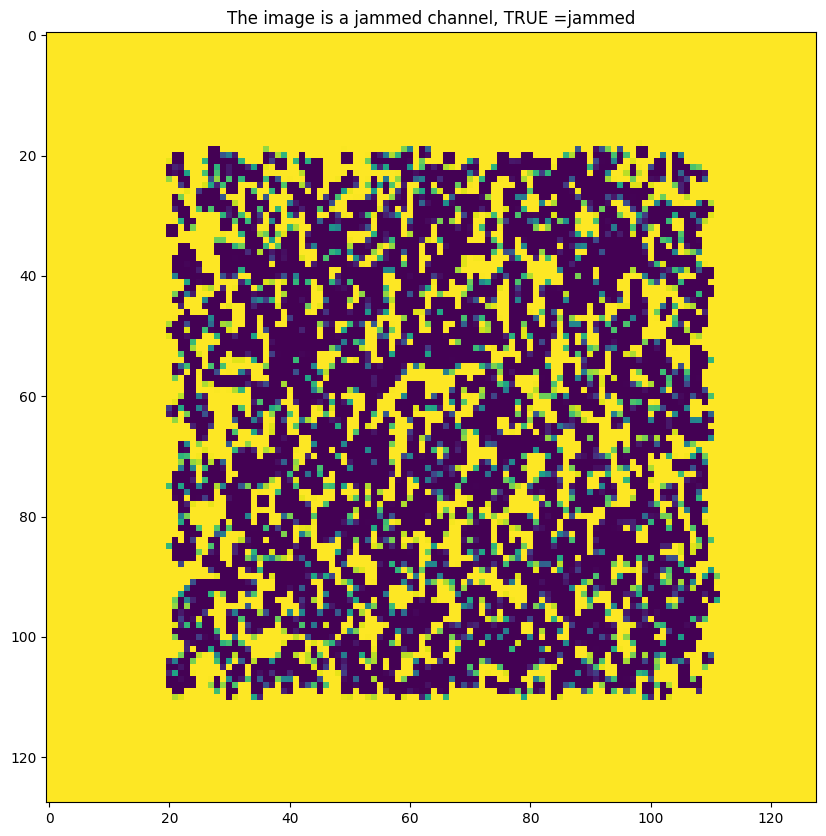

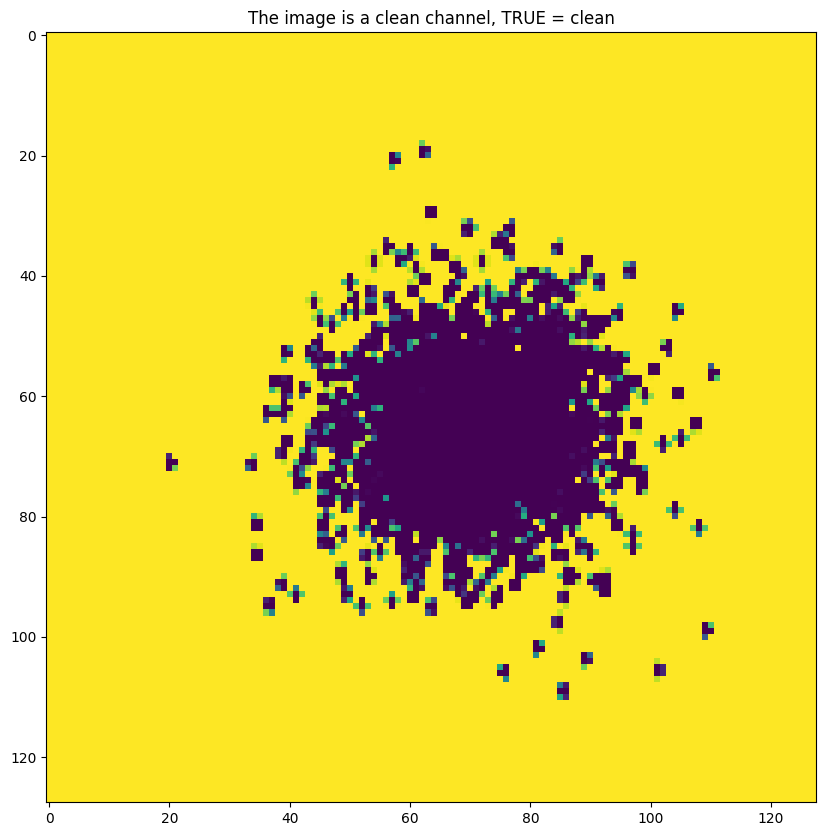

In [18]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [19]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [21]:
values_th=np.arange(min_range_th,max_range_th,0.0005) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

85


In [22]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0351


  0%|          | 1/800 [00:00<02:05,  6.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0345


  0%|          | 3/800 [00:00<01:09, 11.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0635


  1%|          | 5/800 [00:00<01:04, 12.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0341


  1%|          | 7/800 [00:00<00:59, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0640


  1%|          | 9/800 [00:00<00:57, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0639


  1%|▏         | 11/800 [00:00<00:54, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0640


  2%|▏         | 13/800 [00:00<00:55, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0320


  2%|▏         | 15/800 [00:01<00:55, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0375


  2%|▏         | 17/800 [00:01<00:56, 13.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0630


  2%|▏         | 19/800 [00:01<00:55, 13.98it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0641


  3%|▎         | 21/800 [00:01<01:00, 12.81it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0339


  3%|▎         | 23/800 [00:01<01:06, 11.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0355


  3%|▎         | 25/800 [00:01<01:08, 11.23it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0318


  3%|▎         | 27/800 [00:02<01:12, 10.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0366


  4%|▎         | 29/800 [00:02<01:12, 10.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0361


  4%|▍         | 31/800 [00:02<01:17,  9.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0635


  4%|▍         | 33/800 [00:02<01:14, 10.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0314


  4%|▍         | 35/800 [00:03<01:14, 10.20it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0632


  5%|▍         | 37/800 [00:03<01:18,  9.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0356


  5%|▍         | 39/800 [00:03<01:16,  9.92it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0354


  5%|▌         | 41/800 [00:03<01:14, 10.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0364


  5%|▌         | 43/800 [00:03<01:12, 10.49it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0321


  6%|▌         | 45/800 [00:03<01:12, 10.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0639


  6%|▌         | 47/800 [00:04<01:06, 11.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0645


  6%|▌         | 49/800 [00:04<01:03, 11.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0319


  6%|▋         | 51/800 [00:04<00:58, 12.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0633


  7%|▋         | 53/800 [00:04<00:56, 13.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0282


  7%|▋         | 55/800 [00:04<00:56, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0355


  7%|▋         | 57/800 [00:04<00:58, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0631


  7%|▋         | 59/800 [00:05<00:56, 13.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


  8%|▊         | 61/800 [00:05<00:55, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0656


  8%|▊         | 63/800 [00:05<00:54, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


  8%|▊         | 65/800 [00:05<00:53, 13.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0346


  8%|▊         | 67/800 [00:05<00:51, 14.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0631


  9%|▊         | 69/800 [00:05<00:52, 13.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0337


  9%|▉         | 71/800 [00:05<00:55, 13.17it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0619


  9%|▉         | 73/800 [00:06<00:58, 12.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0620


  9%|▉         | 75/800 [00:06<01:00, 11.98it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0347


 10%|▉         | 77/800 [00:06<01:02, 11.54it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0365


 10%|▉         | 79/800 [00:06<01:04, 11.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0631


 10%|█         | 81/800 [00:06<01:06, 10.84it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0343


 10%|█         | 83/800 [00:07<01:09, 10.36it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0635


 11%|█         | 85/800 [00:07<01:07, 10.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0318


 11%|█         | 87/800 [00:07<01:07, 10.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0639


 11%|█         | 89/800 [00:07<01:07, 10.58it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0632


 11%|█▏        | 91/800 [00:07<01:09, 10.19it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0286


 12%|█▏        | 93/800 [00:07<01:08, 10.34it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0626


 12%|█▏        | 95/800 [00:08<01:07, 10.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0628


 12%|█▏        | 97/800 [00:08<01:06, 10.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0641


 12%|█▏        | 99/800 [00:08<01:00, 11.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0335


 13%|█▎        | 101/800 [00:08<00:56, 12.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0367


 13%|█▎        | 103/800 [00:08<00:53, 12.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 13%|█▎        | 105/800 [00:08<00:52, 13.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0635


 13%|█▎        | 107/800 [00:09<00:52, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0338


 14%|█▎        | 109/800 [00:09<00:50, 13.80it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0320


 14%|█▍        | 111/800 [00:09<00:49, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0300


 14%|█▍        | 113/800 [00:09<00:50, 13.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0634


 14%|█▍        | 115/800 [00:09<00:50, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0637


 15%|█▍        | 117/800 [00:09<00:49, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0640


 15%|█▍        | 119/800 [00:09<00:49, 13.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 15%|█▌        | 121/800 [00:10<00:49, 13.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0338


 15%|█▌        | 123/800 [00:10<00:49, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0622


 16%|█▌        | 125/800 [00:10<00:48, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0362


 16%|█▌        | 127/800 [00:10<00:47, 14.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0631


 16%|█▌        | 129/800 [00:10<00:47, 14.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 16%|█▋        | 131/800 [00:10<00:47, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 17%|█▋        | 133/800 [00:10<00:49, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0631


 17%|█▋        | 135/800 [00:11<00:48, 13.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0643


 17%|█▋        | 137/800 [00:11<00:47, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0334


 17%|█▋        | 139/800 [00:11<00:47, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0336


 18%|█▊        | 141/800 [00:11<00:46, 14.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0636


 18%|█▊        | 143/800 [00:11<00:46, 14.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0361


 18%|█▊        | 145/800 [00:11<00:47, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0348


 18%|█▊        | 147/800 [00:11<00:45, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0359


 19%|█▊        | 149/800 [00:12<00:44, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0301


 19%|█▉        | 151/800 [00:12<00:44, 14.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0640


 19%|█▉        | 153/800 [00:12<00:46, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0366


 19%|█▉        | 155/800 [00:12<00:46, 14.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0628


 20%|█▉        | 157/800 [00:12<00:45, 14.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


 20%|█▉        | 159/800 [00:12<00:45, 13.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0334


 20%|██        | 161/800 [00:12<00:46, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 20%|██        | 163/800 [00:13<00:45, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 21%|██        | 165/800 [00:13<00:45, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0326


 21%|██        | 167/800 [00:13<00:45, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 21%|██        | 169/800 [00:13<00:47, 13.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0358


 21%|██▏       | 171/800 [00:13<00:46, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0355


 22%|██▏       | 173/800 [00:13<00:46, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 22%|██▏       | 175/800 [00:13<00:45, 13.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0622


 22%|██▏       | 177/800 [00:14<00:49, 12.66it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0626


 22%|██▏       | 179/800 [00:14<00:51, 12.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0628


 23%|██▎       | 181/800 [00:14<00:52, 11.71it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0304


 23%|██▎       | 183/800 [00:14<00:53, 11.44it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0629


 23%|██▎       | 185/800 [00:14<00:54, 11.18it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0625


 23%|██▎       | 187/800 [00:15<00:57, 10.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0313


 24%|██▎       | 189/800 [00:15<00:57, 10.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0300


 24%|██▍       | 191/800 [00:15<00:57, 10.59it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0628


 24%|██▍       | 193/800 [00:15<00:58, 10.42it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0632


 24%|██▍       | 195/800 [00:15<00:57, 10.59it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0327


 25%|██▍       | 197/800 [00:16<00:56, 10.60it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0342


 25%|██▍       | 199/800 [00:16<00:56, 10.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0624


 25%|██▌       | 201/800 [00:16<00:56, 10.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0631


 25%|██▌       | 203/800 [00:16<00:57, 10.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0630


 26%|██▌       | 205/800 [00:16<00:52, 11.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0639


 26%|██▌       | 207/800 [00:16<00:48, 12.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0357


 26%|██▌       | 209/800 [00:17<00:45, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0292


 26%|██▋       | 211/800 [00:17<00:45, 12.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0370


 27%|██▋       | 213/800 [00:17<00:44, 13.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0625


 27%|██▋       | 215/800 [00:17<00:43, 13.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0649


 27%|██▋       | 217/800 [00:17<00:42, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 27%|██▋       | 219/800 [00:17<00:42, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0626


 28%|██▊       | 221/800 [00:17<00:40, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


 28%|██▊       | 223/800 [00:18<00:40, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0345


 28%|██▊       | 225/800 [00:18<00:40, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0637


 28%|██▊       | 227/800 [00:18<00:39, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0634


 29%|██▊       | 229/800 [00:18<00:39, 14.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0356


 29%|██▉       | 231/800 [00:18<00:39, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0337


 29%|██▉       | 233/800 [00:18<00:40, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0642


 29%|██▉       | 235/800 [00:18<00:39, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0338


 30%|██▉       | 237/800 [00:18<00:39, 14.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0328


 30%|██▉       | 239/800 [00:19<00:40, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 30%|███       | 241/800 [00:19<00:39, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0629


 30%|███       | 243/800 [00:19<00:39, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0633


 31%|███       | 245/800 [00:19<00:38, 14.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0342


 31%|███       | 247/800 [00:19<00:39, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


 31%|███       | 249/800 [00:19<00:37, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0320


 31%|███▏      | 251/800 [00:19<00:37, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0636


 32%|███▏      | 253/800 [00:20<00:38, 14.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0630


 32%|███▏      | 255/800 [00:20<00:38, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0315


 32%|███▏      | 257/800 [00:20<00:38, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0640


 32%|███▏      | 259/800 [00:20<00:37, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0378


 33%|███▎      | 261/800 [00:20<00:38, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0635


 33%|███▎      | 263/800 [00:20<00:37, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0319


 33%|███▎      | 265/800 [00:20<00:36, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0626


 33%|███▎      | 267/800 [00:21<00:36, 14.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 34%|███▎      | 269/800 [00:21<00:36, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0637


 34%|███▍      | 271/800 [00:21<00:35, 14.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0355


 34%|███▍      | 273/800 [00:21<00:36, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


 34%|███▍      | 275/800 [00:21<00:36, 14.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0361


 35%|███▍      | 277/800 [00:21<00:36, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0317


 35%|███▍      | 279/800 [00:21<00:35, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0349


 35%|███▌      | 281/800 [00:22<00:35, 14.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0311


 35%|███▌      | 283/800 [00:22<00:36, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0309


 36%|███▌      | 285/800 [00:22<00:35, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0640


 36%|███▌      | 287/800 [00:22<00:35, 14.39it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0633


 36%|███▌      | 289/800 [00:22<00:36, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0619


 36%|███▋      | 291/800 [00:22<00:36, 14.00it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0292


 37%|███▋      | 293/800 [00:22<00:35, 14.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0351


 37%|███▋      | 295/800 [00:23<00:35, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0315


 37%|███▋      | 297/800 [00:23<00:35, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


 37%|███▋      | 299/800 [00:23<00:34, 14.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0320


 38%|███▊      | 301/800 [00:23<00:34, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


 38%|███▊      | 303/800 [00:23<00:34, 14.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0630


 38%|███▊      | 305/800 [00:23<00:35, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0635


 38%|███▊      | 307/800 [00:23<00:35, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0379


 39%|███▊      | 309/800 [00:24<00:35, 13.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0359


 39%|███▉      | 311/800 [00:24<00:35, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0272


 39%|███▉      | 313/800 [00:24<00:34, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0338


 39%|███▉      | 315/800 [00:24<00:34, 14.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0638


 40%|███▉      | 317/800 [00:24<00:34, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 40%|███▉      | 319/800 [00:24<00:34, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0634


 40%|████      | 321/800 [00:24<00:34, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0327


 40%|████      | 323/800 [00:25<00:33, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0335


 41%|████      | 325/800 [00:25<00:33, 14.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0333


 41%|████      | 327/800 [00:25<00:34, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0337


 41%|████      | 329/800 [00:25<00:34, 13.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0639


 41%|████▏     | 331/800 [00:25<00:33, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0315


 42%|████▏     | 333/800 [00:25<00:34, 13.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0626


 42%|████▏     | 335/800 [00:25<00:33, 13.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0640


 42%|████▏     | 337/800 [00:26<00:33, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0341


 42%|████▏     | 339/800 [00:26<00:33, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 43%|████▎     | 341/800 [00:26<00:33, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 43%|████▎     | 343/800 [00:26<00:32, 13.92it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0631


 43%|████▎     | 345/800 [00:26<00:34, 13.32it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0340


 43%|████▎     | 347/800 [00:26<00:36, 12.37it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0356


 44%|████▎     | 349/800 [00:27<00:37, 11.98it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0635


 44%|████▍     | 351/800 [00:27<00:40, 11.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0621


 44%|████▍     | 353/800 [00:27<00:40, 11.10it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0626


 44%|████▍     | 355/800 [00:27<00:40, 10.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0319


 45%|████▍     | 357/800 [00:27<00:40, 10.88it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0352


 45%|████▍     | 359/800 [00:27<00:41, 10.73it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0310


 45%|████▌     | 361/800 [00:28<00:41, 10.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0619


 45%|████▌     | 363/800 [00:28<00:42, 10.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0355


 46%|████▌     | 365/800 [00:28<00:41, 10.60it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0641


 46%|████▌     | 367/800 [00:28<00:41, 10.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0345


 46%|████▌     | 369/800 [00:28<00:41, 10.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0634


 46%|████▋     | 371/800 [00:29<00:41, 10.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0631


 47%|████▋     | 373/800 [00:29<00:39, 10.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0304


 47%|████▋     | 375/800 [00:29<00:36, 11.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0637


 47%|████▋     | 377/800 [00:29<00:35, 12.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0308


 47%|████▋     | 379/800 [00:29<00:33, 12.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0374


 48%|████▊     | 381/800 [00:29<00:32, 13.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 48%|████▊     | 383/800 [00:30<00:31, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0631


 48%|████▊     | 385/800 [00:30<00:31, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0342


 48%|████▊     | 387/800 [00:30<00:30, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0634


 49%|████▊     | 389/800 [00:30<00:30, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 49%|████▉     | 391/800 [00:30<00:29, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0287


 49%|████▉     | 393/800 [00:30<00:29, 13.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0299


 49%|████▉     | 395/800 [00:30<00:29, 13.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0353


 50%|████▉     | 397/800 [00:31<00:29, 13.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0355


 50%|████▉     | 399/800 [00:31<00:29, 13.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0626


 50%|█████     | 401/800 [00:31<00:28, 13.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


 50%|█████     | 403/800 [00:31<00:29, 13.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0324


 51%|█████     | 405/800 [00:31<00:29, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 51%|█████     | 407/800 [00:31<00:28, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0360


 51%|█████     | 409/800 [00:31<00:28, 13.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0340


 51%|█████▏    | 411/800 [00:32<00:28, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 52%|█████▏    | 413/800 [00:32<00:28, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0633


 52%|█████▏    | 415/800 [00:32<00:28, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0317


 52%|█████▏    | 417/800 [00:32<00:28, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 52%|█████▏    | 419/800 [00:32<00:29, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0271


 53%|█████▎    | 421/800 [00:32<00:28, 13.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0629


 53%|█████▎    | 423/800 [00:33<00:29, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 53%|█████▎    | 425/800 [00:33<00:28, 13.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0321


 53%|█████▎    | 427/800 [00:33<00:27, 13.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0376


 54%|█████▎    | 429/800 [00:33<00:27, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0639


 54%|█████▍    | 431/800 [00:33<00:27, 13.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0317


 54%|█████▍    | 433/800 [00:33<00:27, 13.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0626


 54%|█████▍    | 435/800 [00:33<00:26, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0636


 55%|█████▍    | 437/800 [00:34<00:26, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0643


 55%|█████▍    | 439/800 [00:34<00:26, 13.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0342


 55%|█████▌    | 441/800 [00:34<00:27, 13.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0316


 55%|█████▌    | 443/800 [00:34<00:27, 12.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0634


 56%|█████▌    | 445/800 [00:34<00:27, 12.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0304


 56%|█████▌    | 447/800 [00:34<00:27, 13.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0631


 56%|█████▌    | 449/800 [00:34<00:26, 13.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0625


 56%|█████▋    | 451/800 [00:35<00:26, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 57%|█████▋    | 453/800 [00:35<00:26, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0635


 57%|█████▋    | 455/800 [00:35<00:26, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0635


 57%|█████▋    | 457/800 [00:35<00:25, 13.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0357


 57%|█████▋    | 459/800 [00:35<00:25, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 58%|█████▊    | 461/800 [00:35<00:25, 13.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0313


 58%|█████▊    | 463/800 [00:35<00:24, 13.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0640


 58%|█████▊    | 465/800 [00:36<00:41,  8.00it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0641


 58%|█████▊    | 467/800 [00:36<00:37,  8.90it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0325


 59%|█████▊    | 469/800 [00:36<00:34,  9.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0312


 59%|█████▉    | 471/800 [00:36<00:31, 10.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0632


 59%|█████▉    | 473/800 [00:37<00:30, 10.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0623


 59%|█████▉    | 475/800 [00:37<00:28, 11.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0330


 60%|█████▉    | 477/800 [00:37<00:28, 11.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0374


 60%|█████▉    | 479/800 [00:37<00:27, 11.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0624


 60%|██████    | 481/800 [00:37<00:27, 11.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0620


 60%|██████    | 483/800 [00:37<00:26, 11.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0362


 61%|██████    | 485/800 [00:38<00:26, 11.85it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0323


 61%|██████    | 487/800 [00:38<00:26, 11.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0361


 61%|██████    | 489/800 [00:38<00:25, 12.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0638


 61%|██████▏   | 491/800 [00:38<00:25, 12.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0366


 62%|██████▏   | 493/800 [00:38<00:25, 12.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0625


 62%|██████▏   | 495/800 [00:38<00:25, 12.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0634


 62%|██████▏   | 497/800 [00:39<00:25, 12.08it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0633


 62%|██████▏   | 499/800 [00:39<00:26, 11.52it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0326


 63%|██████▎   | 501/800 [00:39<00:28, 10.61it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0325


 63%|██████▎   | 503/800 [00:39<00:28, 10.34it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0355


 63%|██████▎   | 505/800 [00:39<00:29,  9.92it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0634


 63%|██████▎   | 507/800 [00:40<00:31,  9.41it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0608


 64%|██████▎   | 508/800 [00:40<00:31,  9.19it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0344


 64%|██████▎   | 509/800 [00:40<00:31,  9.24it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0323


 64%|██████▍   | 510/800 [00:40<00:31,  9.26it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0310


 64%|██████▍   | 511/800 [00:40<00:32,  8.88it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0634


 64%|██████▍   | 512/800 [00:40<00:32,  8.94it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0307


 64%|██████▍   | 513/800 [00:40<00:32,  8.90it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0633


 64%|██████▍   | 514/800 [00:40<00:32,  8.84it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0347


 64%|██████▍   | 515/800 [00:41<00:31,  8.95it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0630


 64%|██████▍   | 516/800 [00:41<00:32,  8.86it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0629


 65%|██████▍   | 517/800 [00:41<00:31,  8.96it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0320


 65%|██████▍   | 518/800 [00:41<00:31,  9.06it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0341


 65%|██████▍   | 519/800 [00:41<00:32,  8.57it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0640


 65%|██████▌   | 521/800 [00:41<00:30,  9.16it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0636


 65%|██████▌   | 522/800 [00:41<00:30,  9.14it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0381


 65%|██████▌   | 523/800 [00:41<00:30,  9.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0638


 66%|██████▌   | 525/800 [00:42<00:27, 10.05it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0319


 66%|██████▌   | 527/800 [00:42<00:26, 10.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0373


 66%|██████▌   | 529/800 [00:42<00:24, 10.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0337


 66%|██████▋   | 531/800 [00:42<00:23, 11.29it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0353


 67%|██████▋   | 533/800 [00:42<00:22, 11.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0299


 67%|██████▋   | 535/800 [00:42<00:21, 12.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0350


 67%|██████▋   | 537/800 [00:43<00:20, 12.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0634


 67%|██████▋   | 539/800 [00:43<00:21, 12.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0344


 68%|██████▊   | 541/800 [00:43<00:20, 12.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0311


 68%|██████▊   | 543/800 [00:43<00:20, 12.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0309


 68%|██████▊   | 545/800 [00:43<00:19, 12.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 68%|██████▊   | 547/800 [00:43<00:19, 13.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0294


 69%|██████▊   | 549/800 [00:44<00:19, 12.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0623


 69%|██████▉   | 551/800 [00:44<00:19, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0380


 69%|██████▉   | 553/800 [00:44<00:19, 12.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0632


 69%|██████▉   | 555/800 [00:44<00:19, 12.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0635


 70%|██████▉   | 557/800 [00:44<00:18, 12.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0352


 70%|██████▉   | 559/800 [00:44<00:18, 12.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 70%|███████   | 561/800 [00:44<00:18, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0639


 70%|███████   | 563/800 [00:45<00:17, 13.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0630


 71%|███████   | 565/800 [00:45<00:17, 13.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0624


 71%|███████   | 567/800 [00:45<00:17, 13.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 71%|███████   | 569/800 [00:45<00:17, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0354


 71%|███████▏  | 571/800 [00:45<00:17, 13.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0628


 72%|███████▏  | 573/800 [00:45<00:16, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0352


 72%|███████▏  | 575/800 [00:46<00:16, 13.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 72%|███████▏  | 577/800 [00:46<00:16, 13.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0623


 72%|███████▏  | 579/800 [00:46<00:16, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0312


 73%|███████▎  | 581/800 [00:46<00:16, 13.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0353


 73%|███████▎  | 583/800 [00:46<00:16, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0357


 73%|███████▎  | 585/800 [00:46<00:15, 13.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0630


 73%|███████▎  | 587/800 [00:46<00:15, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 74%|███████▎  | 589/800 [00:47<00:15, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0627


 74%|███████▍  | 591/800 [00:47<00:15, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0617


 74%|███████▍  | 593/800 [00:47<00:15, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0332


 74%|███████▍  | 595/800 [00:47<00:15, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0634


 75%|███████▍  | 597/800 [00:47<00:15, 13.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0330


 75%|███████▍  | 599/800 [00:47<00:14, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0312


 75%|███████▌  | 601/800 [00:47<00:14, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0358


 75%|███████▌  | 603/800 [00:48<00:14, 13.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0616


 76%|███████▌  | 605/800 [00:48<00:14, 13.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0645


 76%|███████▌  | 607/800 [00:48<00:14, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0321


 76%|███████▌  | 609/800 [00:48<00:13, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0243


 76%|███████▋  | 611/800 [00:48<00:13, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0640


 77%|███████▋  | 613/800 [00:48<00:13, 13.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 77%|███████▋  | 615/800 [00:48<00:13, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0362


 77%|███████▋  | 617/800 [00:49<00:13, 13.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0637


 77%|███████▋  | 619/800 [00:49<00:13, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0623


 78%|███████▊  | 621/800 [00:49<00:13, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0322


 78%|███████▊  | 623/800 [00:49<00:12, 13.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0369


 78%|███████▊  | 625/800 [00:49<00:12, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0313


 78%|███████▊  | 627/800 [00:49<00:12, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 79%|███████▊  | 629/800 [00:49<00:12, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0631


 79%|███████▉  | 631/800 [00:50<00:12, 13.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0343


 79%|███████▉  | 633/800 [00:50<00:12, 13.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0622


 79%|███████▉  | 635/800 [00:50<00:11, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 80%|███████▉  | 637/800 [00:50<00:11, 13.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 80%|███████▉  | 639/800 [00:50<00:11, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0637


 80%|████████  | 641/800 [00:50<00:11, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0366


 80%|████████  | 643/800 [00:51<00:11, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0331


 81%|████████  | 645/800 [00:51<00:11, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0621


 81%|████████  | 647/800 [00:51<00:11, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0337


 81%|████████  | 649/800 [00:51<00:11, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


 81%|████████▏ | 651/800 [00:51<00:11, 13.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0357


 82%|████████▏ | 653/800 [00:51<00:10, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 82%|████████▏ | 655/800 [00:51<00:10, 13.47it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0326


 82%|████████▏ | 657/800 [00:52<00:11, 12.32it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0644


 82%|████████▏ | 659/800 [00:52<00:12, 11.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0634


 83%|████████▎ | 661/800 [00:52<00:12, 11.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0300


 83%|████████▎ | 663/800 [00:52<00:12, 11.19it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0355


 83%|████████▎ | 665/800 [00:52<00:12, 10.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0629


 83%|████████▎ | 667/800 [00:53<00:12, 10.92it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0334


 84%|████████▎ | 669/800 [00:53<00:12, 10.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0626


 84%|████████▍ | 671/800 [00:53<00:12, 10.24it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0364


 84%|████████▍ | 673/800 [00:53<00:12, 10.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0639


 84%|████████▍ | 675/800 [00:53<00:12, 10.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0625


 85%|████████▍ | 677/800 [00:54<00:11, 10.67it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0345


 85%|████████▍ | 679/800 [00:54<00:11, 10.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0361


 85%|████████▌ | 681/800 [00:54<00:11, 10.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0336


 85%|████████▌ | 683/800 [00:54<00:11, 10.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0626


 86%|████████▌ | 685/800 [00:54<00:11, 10.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0293


 86%|████████▌ | 687/800 [00:54<00:10, 10.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0631


 86%|████████▌ | 689/800 [00:55<00:09, 11.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0640


 86%|████████▋ | 691/800 [00:55<00:09, 12.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0636


 87%|████████▋ | 693/800 [00:55<00:08, 12.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0626


 87%|████████▋ | 695/800 [00:55<00:08, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0635


 87%|████████▋ | 697/800 [00:55<00:08, 12.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0628


 87%|████████▋ | 699/800 [00:55<00:07, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 88%|████████▊ | 701/800 [00:56<00:07, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0624


 88%|████████▊ | 703/800 [00:56<00:07, 13.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0642


 88%|████████▊ | 705/800 [00:56<00:06, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 88%|████████▊ | 707/800 [00:56<00:06, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0627


 89%|████████▊ | 709/800 [00:56<00:06, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 89%|████████▉ | 711/800 [00:56<00:06, 13.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0622


 89%|████████▉ | 713/800 [00:56<00:06, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 89%|████████▉ | 715/800 [00:57<00:06, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0356


 90%|████████▉ | 717/800 [00:57<00:06, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0633


 90%|████████▉ | 719/800 [00:57<00:06, 13.48it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0366


 90%|█████████ | 721/800 [00:57<00:05, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0300


 90%|█████████ | 723/800 [00:57<00:05, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0641


 91%|█████████ | 725/800 [00:57<00:05, 13.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0636


 91%|█████████ | 727/800 [00:57<00:05, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 91%|█████████ | 729/800 [00:58<00:05, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0632


 91%|█████████▏| 731/800 [00:58<00:05, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0333


 92%|█████████▏| 733/800 [00:58<00:04, 13.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0629


 92%|█████████▏| 735/800 [00:58<00:04, 13.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0630


 92%|█████████▏| 737/800 [00:58<00:04, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0636


 92%|█████████▏| 739/800 [00:58<00:04, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0632


 93%|█████████▎| 741/800 [00:58<00:04, 13.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0627


 93%|█████████▎| 743/800 [00:59<00:04, 13.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0628


 93%|█████████▎| 745/800 [00:59<00:04, 13.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0624


 93%|█████████▎| 747/800 [00:59<00:03, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0629


 94%|█████████▎| 749/800 [00:59<00:03, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0637


 94%|█████████▍| 751/800 [00:59<00:03, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 94%|█████████▍| 753/800 [00:59<00:03, 13.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0637


 94%|█████████▍| 755/800 [00:59<00:03, 13.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0633


 95%|█████████▍| 757/800 [01:00<00:03, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0328


 95%|█████████▍| 759/800 [01:00<00:03, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0635


 95%|█████████▌| 761/800 [01:00<00:02, 13.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0329


 95%|█████████▌| 763/800 [01:00<00:02, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0628


 96%|█████████▌| 765/800 [01:00<00:02, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0329


 96%|█████████▌| 767/800 [01:00<00:02, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 96%|█████████▌| 769/800 [01:01<00:02, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0308


 96%|█████████▋| 771/800 [01:01<00:02, 13.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0363


 97%|█████████▋| 773/800 [01:01<00:02, 12.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0636


 97%|█████████▋| 775/800 [01:01<00:02, 11.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0314


 97%|█████████▋| 777/800 [01:01<00:01, 12.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 97%|█████████▋| 779/800 [01:01<00:01, 12.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 98%|█████████▊| 781/800 [01:01<00:01, 12.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 98%|█████████▊| 783/800 [01:02<00:01, 12.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0638


 98%|█████████▊| 785/800 [01:02<00:01, 12.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0317


 98%|█████████▊| 787/800 [01:02<00:01, 12.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0309


 99%|█████████▊| 789/800 [01:02<00:00, 13.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0366


 99%|█████████▉| 791/800 [01:02<00:00, 13.10it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0635


 99%|█████████▉| 793/800 [01:02<00:00, 12.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0356


 99%|█████████▉| 795/800 [01:03<00:00, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0293


100%|█████████▉| 797/800 [01:03<00:00, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0347


100%|█████████▉| 799/800 [01:03<00:00, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0335


100%|██████████| 800/800 [01:03<00:00, 12.61it/s]

800


In [23]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [24]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [25]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00125, 0.005, 0.04625, 0.1375, 0.32, 0.4375, 0.495]
[0.5, 0.5, 0.5, 0.5, 0.49875, 0.49875, 0.49875, 0.49875, 0.4975, 0.4975, 0.495, 0.495, 0.49125, 0.485, 0.475, 0.465, 0.45375, 0.44, 0.41125, 0.3775, 0.32875, 0.29375, 0.2725, 0.24, 0.21875, 0.18625, 0.14875, 0.0975, 0.06625, 0.045, 0.035, 0.0225, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375, 0.01375

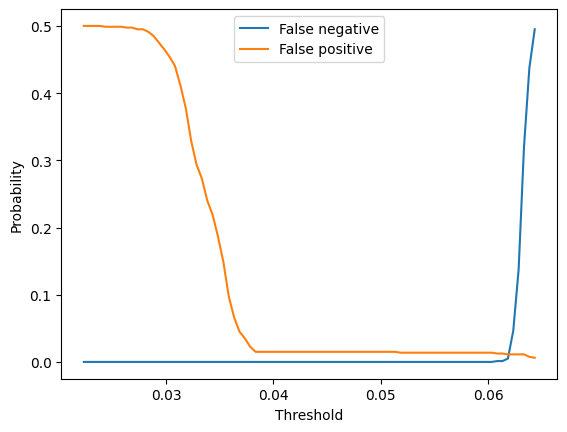

In [26]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [27]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0321


  0%|          | 2/800 [00:00<00:57, 13.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0630


  0%|          | 4/800 [00:00<01:04, 12.36it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0629


  1%|          | 6/800 [00:00<01:06, 11.93it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0343


  1%|          | 8/800 [00:00<01:13, 10.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0334


  1%|▏         | 10/800 [00:00<01:10, 11.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0320


  2%|▏         | 12/800 [00:01<01:10, 11.13it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0619


  2%|▏         | 14/800 [00:01<01:11, 11.00it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0335


  2%|▏         | 16/800 [00:01<01:14, 10.51it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0357


  2%|▏         | 18/800 [00:01<01:19,  9.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0630


  2%|▏         | 19/800 [00:01<01:19,  9.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0641


  3%|▎         | 21/800 [00:01<01:16, 10.23it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0339


  3%|▎         | 23/800 [00:02<01:14, 10.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0355


  3%|▎         | 25/800 [00:02<01:13, 10.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0318


  3%|▎         | 27/800 [00:02<01:12, 10.63it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0366


  4%|▎         | 29/800 [00:02<01:15, 10.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0361


  4%|▍         | 31/800 [00:02<01:08, 11.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0635


  4%|▍         | 33/800 [00:03<01:04, 11.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0314


  4%|▍         | 35/800 [00:03<01:01, 12.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0632


  5%|▍         | 37/800 [00:03<00:57, 13.28it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0356


  5%|▍         | 39/800 [00:03<01:02, 12.16it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0354


  5%|▌         | 41/800 [00:03<01:08, 11.02it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0364


  5%|▌         | 43/800 [00:03<01:19,  9.53it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0321


  6%|▌         | 45/800 [00:04<01:20,  9.38it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0319


  6%|▌         | 46/800 [00:04<01:27,  8.58it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0639


  6%|▌         | 47/800 [00:04<01:25,  8.82it/s]

1/1 [==============================] - 0s 123ms/step - loss: 0.0645


  6%|▌         | 49/800 [00:04<01:53,  6.59it/s]

1/1 [==============================] - 0s 114ms/step - loss: 0.0361


  6%|▋         | 50/800 [00:05<02:17,  5.47it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0319


  6%|▋         | 51/800 [00:05<02:17,  5.46it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0621


  6%|▋         | 52/800 [00:05<02:05,  5.96it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0633


  7%|▋         | 53/800 [00:05<02:07,  5.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0306


  7%|▋         | 54/800 [00:05<01:58,  6.30it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0282


  7%|▋         | 55/800 [00:05<01:56,  6.40it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0363


  7%|▋         | 56/800 [00:06<01:52,  6.62it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0355


  7%|▋         | 57/800 [00:06<01:42,  7.25it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0630


  7%|▋         | 58/800 [00:06<01:39,  7.47it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0631


  7%|▋         | 59/800 [00:06<02:05,  5.92it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0351


  8%|▊         | 60/800 [00:06<01:53,  6.50it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0631


  8%|▊         | 61/800 [00:06<01:53,  6.52it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0638


  8%|▊         | 62/800 [00:06<01:45,  6.99it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0656


  8%|▊         | 63/800 [00:07<01:50,  6.67it/s]

1/1 [==============================] - 0s 62ms/step - loss: 0.0638


  8%|▊         | 64/800 [00:07<01:44,  7.03it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0629


  8%|▊         | 66/800 [00:07<01:37,  7.55it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0346


  8%|▊         | 67/800 [00:07<01:51,  6.60it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0615


  8%|▊         | 68/800 [00:07<01:44,  7.03it/s]

1/1 [==============================] - 0s 78ms/step - loss: 0.0631


  9%|▊         | 69/800 [00:08<02:00,  6.06it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0361


  9%|▉         | 70/800 [00:08<01:52,  6.52it/s]

1/1 [==============================] - 0s 71ms/step - loss: 0.0337


  9%|▉         | 71/800 [00:08<01:50,  6.62it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0351


  9%|▉         | 72/800 [00:08<01:57,  6.18it/s]

1/1 [==============================] - 0s 80ms/step - loss: 0.0619


  9%|▉         | 73/800 [00:08<02:12,  5.48it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0358


  9%|▉         | 74/800 [00:08<02:00,  6.03it/s]

1/1 [==============================] - 0s 104ms/step - loss: 0.0620


  9%|▉         | 75/800 [00:09<02:18,  5.22it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0322


 10%|▉         | 76/800 [00:09<02:06,  5.74it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0347


 10%|▉         | 77/800 [00:09<02:03,  5.87it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0337


 10%|▉         | 78/800 [00:09<02:06,  5.70it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0365


 10%|▉         | 79/800 [00:09<02:01,  5.94it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0311


 10%|█         | 80/800 [00:09<01:52,  6.39it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0631


 10%|█         | 81/800 [00:10<01:55,  6.24it/s]

1/1 [==============================] - 0s 90ms/step - loss: 0.0322


 10%|█         | 82/800 [00:10<02:19,  5.13it/s]

1/1 [==============================] - 0s 97ms/step - loss: 0.0343


 10%|█         | 83/800 [00:10<02:28,  4.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0373


 10%|█         | 84/800 [00:10<02:18,  5.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0350


 11%|█         | 86/800 [00:10<01:38,  7.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0356


 11%|█         | 88/800 [00:11<01:18,  9.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0340


 11%|█▏        | 90/800 [00:11<01:07, 10.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0642


 12%|█▏        | 92/800 [00:11<00:59, 11.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 12%|█▏        | 94/800 [00:11<00:56, 12.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0628


 12%|█▏        | 96/800 [00:11<00:55, 12.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0625


 12%|█▏        | 98/800 [00:11<00:52, 13.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0308


 12%|█▎        | 100/800 [00:11<00:50, 13.85it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0348


 13%|█▎        | 102/800 [00:11<00:51, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0314


 13%|█▎        | 104/800 [00:12<00:50, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0639


 13%|█▎        | 106/800 [00:12<00:50, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0636


 14%|█▎        | 108/800 [00:12<00:49, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0376


 14%|█▍        | 110/800 [00:12<00:48, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0333


 14%|█▍        | 112/800 [00:12<00:47, 14.54it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0632


 14%|█▍        | 114/800 [00:12<00:50, 13.64it/s]

1/1 [==============================] - 0s 124ms/step - loss: 0.0358


 14%|█▍        | 116/800 [00:13<01:15,  9.07it/s]

1/1 [==============================] - 0s 78ms/step - loss: 0.0638


 15%|█▍        | 118/800 [00:13<01:43,  6.57it/s]

1/1 [==============================] - 0s 124ms/step - loss: 0.0640


 15%|█▍        | 119/800 [00:14<02:00,  5.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0291


 15%|█▌        | 120/800 [00:14<01:57,  5.79it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0625


 15%|█▌        | 122/800 [00:14<01:36,  7.04it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0345


 16%|█▌        | 124/800 [00:14<01:23,  8.12it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0639


 16%|█▌        | 126/800 [00:14<01:16,  8.81it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0625


 16%|█▌        | 128/800 [00:14<01:13,  9.15it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0631


 16%|█▌        | 129/800 [00:15<01:12,  9.26it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0629


 16%|█▋        | 131/800 [00:15<01:08,  9.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0630


 17%|█▋        | 133/800 [00:15<01:06, 10.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0631


 17%|█▋        | 135/800 [00:15<01:02, 10.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0643


 17%|█▋        | 137/800 [00:15<00:58, 11.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0334


 17%|█▋        | 139/800 [00:15<00:55, 11.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0336


 18%|█▊        | 141/800 [00:15<00:51, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0636


 18%|█▊        | 143/800 [00:16<00:49, 13.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0361


 18%|█▊        | 145/800 [00:16<00:48, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0348


 18%|█▊        | 147/800 [00:16<00:46, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0359


 19%|█▊        | 149/800 [00:16<00:46, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0301


 19%|█▉        | 151/800 [00:16<00:50, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0640


 19%|█▉        | 153/800 [00:16<00:49, 13.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0366


 19%|█▉        | 155/800 [00:17<00:48, 13.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0628


 20%|█▉        | 157/800 [00:17<00:49, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 20%|█▉        | 159/800 [00:17<00:47, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0334


 20%|██        | 161/800 [00:17<00:45, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 20%|██        | 163/800 [00:17<00:45, 13.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0629


 21%|██        | 165/800 [00:17<00:45, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0326


 21%|██        | 167/800 [00:17<00:44, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 21%|██        | 169/800 [00:18<00:44, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0358


 21%|██▏       | 171/800 [00:18<00:44, 14.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0355


 22%|██▏       | 173/800 [00:18<00:45, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 22%|██▏       | 175/800 [00:18<00:45, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0622


 22%|██▏       | 177/800 [00:18<00:43, 14.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0626


 22%|██▏       | 179/800 [00:18<00:44, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0628


 23%|██▎       | 181/800 [00:18<00:44, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0304


 23%|██▎       | 183/800 [00:19<00:43, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 23%|██▎       | 185/800 [00:19<00:42, 14.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 23%|██▎       | 187/800 [00:19<00:44, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0313


 24%|██▎       | 189/800 [00:19<00:44, 13.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0300


 24%|██▍       | 191/800 [00:19<00:43, 14.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 24%|██▍       | 193/800 [00:19<00:43, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0632


 24%|██▍       | 195/800 [00:19<00:42, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0327


 25%|██▍       | 197/800 [00:20<00:42, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0342


 25%|██▍       | 199/800 [00:20<00:42, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0624


 25%|██▌       | 201/800 [00:20<00:42, 14.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0631


 25%|██▌       | 203/800 [00:20<00:41, 14.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 26%|██▌       | 205/800 [00:20<00:40, 14.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0639


 26%|██▌       | 207/800 [00:20<00:41, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0357


 26%|██▌       | 209/800 [00:20<00:41, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0292


 26%|██▋       | 211/800 [00:20<00:40, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0370


 27%|██▋       | 213/800 [00:21<00:41, 14.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 27%|██▋       | 215/800 [00:21<00:42, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0649


 27%|██▋       | 217/800 [00:21<00:41, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 27%|██▋       | 219/800 [00:21<00:40, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 28%|██▊       | 221/800 [00:21<00:39, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 28%|██▊       | 223/800 [00:21<00:41, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0345


 28%|██▊       | 225/800 [00:21<00:40, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0637


 28%|██▊       | 227/800 [00:22<00:41, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 29%|██▊       | 229/800 [00:22<00:40, 14.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0356


 29%|██▉       | 231/800 [00:22<00:41, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0337


 29%|██▉       | 233/800 [00:22<00:40, 14.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0642


 29%|██▉       | 235/800 [00:22<00:40, 14.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0338


 30%|██▉       | 237/800 [00:22<00:40, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0328


 30%|██▉       | 239/800 [00:22<00:40, 13.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0320


 30%|███       | 241/800 [00:23<00:40, 13.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 30%|███       | 243/800 [00:23<00:39, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 31%|███       | 245/800 [00:23<00:39, 14.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0342


 31%|███       | 247/800 [00:23<00:39, 13.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0632


 31%|███       | 249/800 [00:23<00:40, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0320


 31%|███▏      | 251/800 [00:23<00:40, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0636


 32%|███▏      | 253/800 [00:23<00:39, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 32%|███▏      | 255/800 [00:24<00:38, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0315


 32%|███▏      | 257/800 [00:24<00:38, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0640


 32%|███▏      | 259/800 [00:24<00:39, 13.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0378


 33%|███▎      | 261/800 [00:24<00:39, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0635


 33%|███▎      | 263/800 [00:24<00:39, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0319


 33%|███▎      | 265/800 [00:24<00:38, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0626


 33%|███▎      | 267/800 [00:25<00:38, 13.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 34%|███▎      | 269/800 [00:25<00:38, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0637


 34%|███▍      | 271/800 [00:25<00:38, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0355


 34%|███▍      | 273/800 [00:25<00:38, 13.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0631


 34%|███▍      | 275/800 [00:25<00:40, 13.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0361


 35%|███▍      | 277/800 [00:25<00:43, 12.06it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0317


 35%|███▍      | 279/800 [00:25<00:45, 11.52it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0349


 35%|███▌      | 281/800 [00:26<00:44, 11.76it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0311


 35%|███▌      | 283/800 [00:26<00:45, 11.47it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0309


 36%|███▌      | 285/800 [00:26<00:45, 11.21it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0640


 36%|███▌      | 287/800 [00:26<00:46, 11.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0633


 36%|███▌      | 289/800 [00:26<00:46, 11.00it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0619


 36%|███▋      | 291/800 [00:27<00:48, 10.43it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0292


 37%|███▋      | 293/800 [00:27<00:48, 10.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0351


 37%|███▋      | 295/800 [00:27<00:47, 10.58it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0315


 37%|███▋      | 297/800 [00:27<00:48, 10.37it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0629


 37%|███▋      | 299/800 [00:27<00:49, 10.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0320


 38%|███▊      | 301/800 [00:28<00:48, 10.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0633


 38%|███▊      | 303/800 [00:28<00:46, 10.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0630


 38%|███▊      | 305/800 [00:28<00:41, 11.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0635


 38%|███▊      | 307/800 [00:28<00:39, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0379


 39%|███▊      | 309/800 [00:28<00:38, 12.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0359


 39%|███▉      | 311/800 [00:28<00:37, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0272


 39%|███▉      | 313/800 [00:28<00:36, 13.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0338


 39%|███▉      | 315/800 [00:29<00:36, 13.32it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0638


 40%|███▉      | 317/800 [00:29<00:36, 13.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


 40%|███▉      | 319/800 [00:29<00:36, 13.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0634


 40%|████      | 321/800 [00:29<00:35, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0327


 40%|████      | 323/800 [00:29<00:34, 13.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0335


 41%|████      | 325/800 [00:29<00:35, 13.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0333


 41%|████      | 327/800 [00:29<00:34, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0337


 41%|████      | 329/800 [00:30<00:34, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0639


 41%|████▏     | 331/800 [00:30<00:35, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0315


 42%|████▏     | 333/800 [00:30<00:33, 13.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 42%|████▏     | 335/800 [00:30<00:33, 13.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0640


 42%|████▏     | 337/800 [00:30<00:33, 13.77it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0341


 42%|████▏     | 339/800 [00:30<00:33, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0629


 43%|████▎     | 341/800 [00:30<00:32, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


 43%|████▎     | 343/800 [00:31<00:32, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0631


 43%|████▎     | 345/800 [00:31<00:31, 14.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0340


 43%|████▎     | 347/800 [00:31<00:31, 14.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0356


 44%|████▎     | 349/800 [00:31<00:32, 14.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0635


 44%|████▍     | 351/800 [00:31<00:32, 14.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0621


 44%|████▍     | 353/800 [00:31<00:32, 13.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0626


 44%|████▍     | 355/800 [00:31<00:32, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0319


 45%|████▍     | 357/800 [00:32<00:32, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0352


 45%|████▍     | 359/800 [00:32<00:32, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0310


 45%|████▌     | 361/800 [00:32<00:31, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0619


 45%|████▌     | 363/800 [00:32<00:31, 13.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0355


 46%|████▌     | 365/800 [00:32<00:31, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0641


 46%|████▌     | 367/800 [00:32<00:31, 13.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0345


 46%|████▌     | 369/800 [00:33<00:30, 14.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0634


 46%|████▋     | 371/800 [00:33<00:30, 14.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 47%|████▋     | 373/800 [00:33<00:29, 14.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0304


 47%|████▋     | 375/800 [00:33<00:30, 13.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0637


 47%|████▋     | 377/800 [00:33<00:31, 13.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0308


 47%|████▋     | 379/800 [00:33<00:31, 13.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0374


 48%|████▊     | 381/800 [00:33<00:31, 13.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0630


 48%|████▊     | 383/800 [00:34<00:30, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0631


 48%|████▊     | 385/800 [00:34<00:30, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0342


 48%|████▊     | 387/800 [00:34<00:30, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0634


 49%|████▊     | 389/800 [00:34<00:29, 13.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0622


 49%|████▉     | 391/800 [00:34<00:29, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0287


 49%|████▉     | 393/800 [00:34<00:30, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0299


 49%|████▉     | 395/800 [00:34<00:29, 13.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0353


 50%|████▉     | 397/800 [00:35<00:29, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0355


 50%|████▉     | 399/800 [00:35<00:28, 14.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0626


 50%|█████     | 401/800 [00:35<00:28, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0631


 50%|█████     | 403/800 [00:35<00:28, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0324


 51%|█████     | 405/800 [00:35<00:29, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 51%|█████     | 407/800 [00:35<00:29, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0360


 51%|█████     | 409/800 [00:35<00:28, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0340


 51%|█████▏    | 411/800 [00:36<00:27, 13.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 52%|█████▏    | 413/800 [00:36<00:29, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


 52%|█████▏    | 415/800 [00:36<00:28, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0317


 52%|█████▏    | 417/800 [00:36<00:29, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0626


 52%|█████▏    | 419/800 [00:36<00:28, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0271


 53%|█████▎    | 421/800 [00:36<00:28, 13.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0629


 53%|█████▎    | 423/800 [00:36<00:28, 13.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0310


 53%|█████▎    | 425/800 [00:37<00:28, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0321


 53%|█████▎    | 427/800 [00:37<00:27, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0376


 54%|█████▎    | 429/800 [00:37<00:27, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0639


 54%|█████▍    | 431/800 [00:37<00:27, 13.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0317


 54%|█████▍    | 433/800 [00:37<00:26, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0626


 54%|█████▍    | 435/800 [00:37<00:27, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0636


 55%|█████▍    | 437/800 [00:38<00:26, 13.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0643


 55%|█████▍    | 439/800 [00:38<00:26, 13.83it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0342


 55%|█████▌    | 441/800 [00:38<00:28, 12.45it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0316


 55%|█████▌    | 443/800 [00:38<00:30, 11.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0634


 56%|█████▌    | 445/800 [00:38<00:31, 11.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0304


 56%|█████▌    | 447/800 [00:38<00:33, 10.67it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0631


 56%|█████▌    | 449/800 [00:39<00:32, 10.64it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0625


 56%|█████▋    | 451/800 [00:39<00:33, 10.29it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0320


 57%|█████▋    | 453/800 [00:39<00:34, 10.08it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0635


 57%|█████▋    | 455/800 [00:39<00:34,  9.86it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0629


 57%|█████▋    | 456/800 [00:39<00:35,  9.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0635


 57%|█████▋    | 457/800 [00:39<00:35,  9.63it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0634


 57%|█████▋    | 458/800 [00:40<00:35,  9.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0323


 57%|█████▊    | 460/800 [00:40<00:34,  9.98it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0320


 58%|█████▊    | 461/800 [00:40<00:34,  9.86it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0313


 58%|█████▊    | 463/800 [00:40<00:33, 10.02it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0348


 58%|█████▊    | 464/800 [00:40<00:33, 10.00it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0640


 58%|█████▊    | 465/800 [00:40<00:36,  9.27it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0633


 58%|█████▊    | 466/800 [00:40<00:36,  9.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0318


 58%|█████▊    | 468/800 [00:41<00:33,  9.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0638


 59%|█████▉    | 470/800 [00:41<00:30, 10.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0322


 59%|█████▉    | 472/800 [00:41<00:28, 11.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0336


 59%|█████▉    | 474/800 [00:41<00:26, 12.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0633


 60%|█████▉    | 476/800 [00:41<00:26, 12.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0319


 60%|█████▉    | 478/800 [00:41<00:26, 12.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0351


 60%|██████    | 480/800 [00:42<00:25, 12.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0630


 60%|██████    | 482/800 [00:42<00:25, 12.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0309


 60%|██████    | 484/800 [00:42<00:24, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0313


 61%|██████    | 486/800 [00:42<00:23, 13.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0631


 61%|██████    | 488/800 [00:42<00:23, 13.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0326


 61%|██████▏   | 490/800 [00:42<00:23, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 62%|██████▏   | 492/800 [00:42<00:23, 13.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0631


 62%|██████▏   | 494/800 [00:43<00:22, 13.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0635


 62%|██████▏   | 496/800 [00:43<00:22, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0317


 62%|██████▏   | 498/800 [00:43<00:22, 13.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0635


 62%|██████▎   | 500/800 [00:43<00:22, 13.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0628


 63%|██████▎   | 502/800 [00:43<00:22, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0344


 63%|██████▎   | 504/800 [00:43<00:22, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0355


 63%|██████▎   | 506/800 [00:43<00:21, 13.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0608


 64%|██████▎   | 508/800 [00:44<00:22, 13.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0323


 64%|██████▍   | 510/800 [00:44<00:21, 13.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 64%|██████▍   | 512/800 [00:44<00:21, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0633


 64%|██████▍   | 514/800 [00:44<00:20, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0630


 64%|██████▍   | 516/800 [00:44<00:20, 13.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0320


 65%|██████▍   | 518/800 [00:45<00:34,  8.09it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0376


 65%|██████▌   | 520/800 [00:45<00:31,  8.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0636


 65%|██████▌   | 522/800 [00:45<00:28,  9.68it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0628


 66%|██████▌   | 524/800 [00:45<00:27, 10.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0629


 66%|██████▌   | 526/800 [00:45<00:25, 10.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0365


 66%|██████▌   | 528/800 [00:46<00:24, 11.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0638


 66%|██████▋   | 530/800 [00:46<00:24, 11.24it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0633


 66%|██████▋   | 532/800 [00:46<00:23, 11.26it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0628


 67%|██████▋   | 534/800 [00:46<00:23, 11.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0652


 67%|██████▋   | 536/800 [00:46<00:22, 11.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0633


 67%|██████▋   | 538/800 [00:46<00:22, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0304


 68%|██████▊   | 540/800 [00:47<00:22, 11.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0356


 68%|██████▊   | 542/800 [00:47<00:22, 11.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0322


 68%|██████▊   | 544/800 [00:47<00:22, 11.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0638


 68%|██████▊   | 546/800 [00:47<00:21, 11.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0321


 68%|██████▊   | 548/800 [00:47<00:21, 11.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0636


 69%|██████▉   | 550/800 [00:47<00:20, 12.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0628


 69%|██████▉   | 552/800 [00:48<00:21, 11.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0636


 69%|██████▉   | 554/800 [00:48<00:20, 11.83it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0622


 70%|██████▉   | 556/800 [00:48<00:20, 11.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0380


 70%|██████▉   | 558/800 [00:48<00:20, 11.72it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0631


 70%|███████   | 560/800 [00:48<00:20, 11.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0630


 70%|███████   | 562/800 [00:48<00:20, 11.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0359


 70%|███████   | 564/800 [00:49<00:19, 11.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0318


 71%|███████   | 566/800 [00:49<00:19, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0293


 71%|███████   | 568/800 [00:49<00:19, 11.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0315


 71%|███████▏  | 570/800 [00:49<00:19, 11.68it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0338


 72%|███████▏  | 572/800 [00:49<00:19, 11.74it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0358


 72%|███████▏  | 574/800 [00:49<00:19, 11.70it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0313


 72%|███████▏  | 576/800 [00:50<00:19, 11.55it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0283


 72%|███████▏  | 578/800 [00:50<00:18, 11.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0322


 72%|███████▎  | 580/800 [00:50<00:18, 11.68it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0317


 73%|███████▎  | 582/800 [00:50<00:18, 11.51it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0369


 73%|███████▎  | 584/800 [00:50<00:18, 11.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0623


 73%|███████▎  | 586/800 [00:50<00:17, 11.98it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0348


 74%|███████▎  | 588/800 [00:51<00:18, 11.35it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0620


 74%|███████▍  | 590/800 [00:51<00:19, 10.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0607


 74%|███████▍  | 592/800 [00:51<00:19, 10.63it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0639


 74%|███████▍  | 594/800 [00:51<00:20, 10.11it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0636


 74%|███████▍  | 596/800 [00:51<00:20,  9.89it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0634


 75%|███████▍  | 597/800 [00:52<00:21,  9.65it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0325


 75%|███████▍  | 598/800 [00:52<00:21,  9.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0369


 75%|███████▌  | 600/800 [00:52<00:19, 10.28it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0633


 75%|███████▌  | 602/800 [00:52<00:19, 10.24it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0640


 76%|███████▌  | 604/800 [00:52<00:19, 10.10it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0642


 76%|███████▌  | 606/800 [00:52<00:18, 10.38it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0373


 76%|███████▌  | 608/800 [00:53<00:18, 10.45it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0633


 76%|███████▋  | 610/800 [00:53<00:18, 10.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0631


 76%|███████▋  | 612/800 [00:53<00:18, 10.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0338


 77%|███████▋  | 614/800 [00:53<00:18,  9.98it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0634


 77%|███████▋  | 615/800 [00:53<00:18,  9.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0362


 77%|███████▋  | 617/800 [00:54<00:17, 10.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0637


 77%|███████▋  | 619/800 [00:54<00:16, 10.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0623


 78%|███████▊  | 621/800 [00:54<00:15, 11.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0322


 78%|███████▊  | 623/800 [00:54<00:14, 12.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0369


 78%|███████▊  | 625/800 [00:54<00:13, 12.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0313


 78%|███████▊  | 627/800 [00:54<00:13, 12.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 79%|███████▊  | 629/800 [00:54<00:13, 12.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0631


 79%|███████▉  | 631/800 [00:55<00:13, 12.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0343


 79%|███████▉  | 633/800 [00:55<00:13, 12.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 79%|███████▉  | 635/800 [00:55<00:12, 12.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0633


 80%|███████▉  | 637/800 [00:55<00:12, 13.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0629


 80%|███████▉  | 639/800 [00:55<00:12, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0637


 80%|████████  | 641/800 [00:55<00:11, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0366


 80%|████████  | 643/800 [00:55<00:11, 13.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0331


 81%|████████  | 645/800 [00:56<00:11, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0621


 81%|████████  | 647/800 [00:56<00:11, 13.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0337


 81%|████████  | 649/800 [00:56<00:11, 13.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0633


 81%|████████▏ | 651/800 [00:56<00:11, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0357


 82%|████████▏ | 653/800 [00:56<00:11, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0632


 82%|████████▏ | 655/800 [00:56<00:10, 13.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0326


 82%|████████▏ | 657/800 [00:57<00:10, 13.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0644


 82%|████████▏ | 659/800 [00:57<00:10, 13.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0634


 83%|████████▎ | 661/800 [00:57<00:10, 13.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0300


 83%|████████▎ | 663/800 [00:57<00:10, 13.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0355


 83%|████████▎ | 665/800 [00:57<00:09, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


 83%|████████▎ | 667/800 [00:57<00:09, 13.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0334


 84%|████████▎ | 669/800 [00:57<00:09, 13.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0626


 84%|████████▍ | 671/800 [00:58<00:09, 13.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0364


 84%|████████▍ | 673/800 [00:58<00:09, 13.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0639


 84%|████████▍ | 675/800 [00:58<00:09, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0625


 85%|████████▍ | 677/800 [00:58<00:09, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0345


 85%|████████▍ | 679/800 [00:58<00:08, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0361


 85%|████████▌ | 681/800 [00:58<00:08, 13.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0336


 85%|████████▌ | 683/800 [00:58<00:08, 13.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0626


 86%|████████▌ | 685/800 [00:59<00:08, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0293


 86%|████████▌ | 687/800 [00:59<00:08, 13.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0631


 86%|████████▌ | 689/800 [00:59<00:08, 13.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0640


 86%|████████▋ | 691/800 [00:59<00:08, 12.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0636


 87%|████████▋ | 693/800 [00:59<00:08, 12.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0626


 87%|████████▋ | 695/800 [00:59<00:08, 12.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0635


 87%|████████▋ | 697/800 [01:00<00:07, 12.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0628


 87%|████████▋ | 699/800 [01:00<00:07, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 88%|████████▊ | 701/800 [01:00<00:07, 12.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0624


 88%|████████▊ | 703/800 [01:00<00:07, 13.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0642


 88%|████████▊ | 705/800 [01:00<00:07, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0289


 88%|████████▊ | 707/800 [01:00<00:06, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0627


 89%|████████▊ | 709/800 [01:00<00:06, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 89%|████████▉ | 711/800 [01:01<00:06, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0622


 89%|████████▉ | 713/800 [01:01<00:06, 13.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0626


 89%|████████▉ | 715/800 [01:01<00:06, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0356


 90%|████████▉ | 717/800 [01:01<00:06, 13.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0633


 90%|████████▉ | 719/800 [01:01<00:05, 13.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0366


 90%|█████████ | 721/800 [01:01<00:05, 13.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0300


 90%|█████████ | 723/800 [01:02<00:05, 13.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0641


 91%|█████████ | 725/800 [01:02<00:05, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0636


 91%|█████████ | 727/800 [01:02<00:05, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0628


 91%|█████████ | 729/800 [01:02<00:05, 13.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0632


 91%|█████████▏| 731/800 [01:02<00:05, 12.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0333


 92%|█████████▏| 733/800 [01:02<00:05, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0629


 92%|█████████▏| 735/800 [01:02<00:04, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0630


 92%|█████████▏| 737/800 [01:03<00:04, 13.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0636


 92%|█████████▏| 739/800 [01:03<00:04, 13.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0632


 93%|█████████▎| 741/800 [01:03<00:04, 13.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0627


 93%|█████████▎| 743/800 [01:03<00:04, 13.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0628


 93%|█████████▎| 745/800 [01:03<00:04, 13.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0624


 93%|█████████▎| 747/800 [01:03<00:04, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0629


 94%|█████████▎| 749/800 [01:03<00:03, 13.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0637


 94%|█████████▍| 751/800 [01:04<00:04, 12.23it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0630


 94%|█████████▍| 753/800 [01:04<00:04, 11.60it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0637


 94%|█████████▍| 755/800 [01:04<00:04, 10.68it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0633


 95%|█████████▍| 757/800 [01:04<00:03, 10.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0328


 95%|█████████▍| 759/800 [01:04<00:03, 10.89it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0635


 95%|█████████▌| 761/800 [01:05<00:03, 10.50it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0329


 95%|█████████▌| 763/800 [01:05<00:03, 10.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0628


 96%|█████████▌| 765/800 [01:05<00:03, 10.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0329


 96%|█████████▌| 767/800 [01:05<00:03, 10.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0636


 96%|█████████▌| 769/800 [01:05<00:02, 10.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0308


 96%|█████████▋| 771/800 [01:06<00:02, 10.48it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0363


 97%|█████████▋| 773/800 [01:06<00:02, 10.14it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0636


 97%|█████████▋| 775/800 [01:06<00:02,  9.99it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0314


 97%|█████████▋| 777/800 [01:06<00:02,  9.84it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0628


 97%|█████████▋| 779/800 [01:06<00:02,  9.75it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0309


 98%|█████████▊| 780/800 [01:07<00:02,  9.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0633


 98%|█████████▊| 782/800 [01:07<00:01, 10.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0632


 98%|█████████▊| 784/800 [01:07<00:01, 11.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0353


 98%|█████████▊| 786/800 [01:07<00:01, 11.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0314


 98%|█████████▊| 788/800 [01:07<00:00, 12.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0335


 99%|█████████▉| 790/800 [01:07<00:00, 12.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0638


 99%|█████████▉| 792/800 [01:07<00:00, 12.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0629


 99%|█████████▉| 794/800 [01:08<00:00, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0304


100%|█████████▉| 796/800 [01:08<00:00, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0348


100%|█████████▉| 798/800 [01:08<00:00, 13.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0335


100%|██████████| 800/800 [01:08<00:00, 11.66it/s]


In [28]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 95.0 %


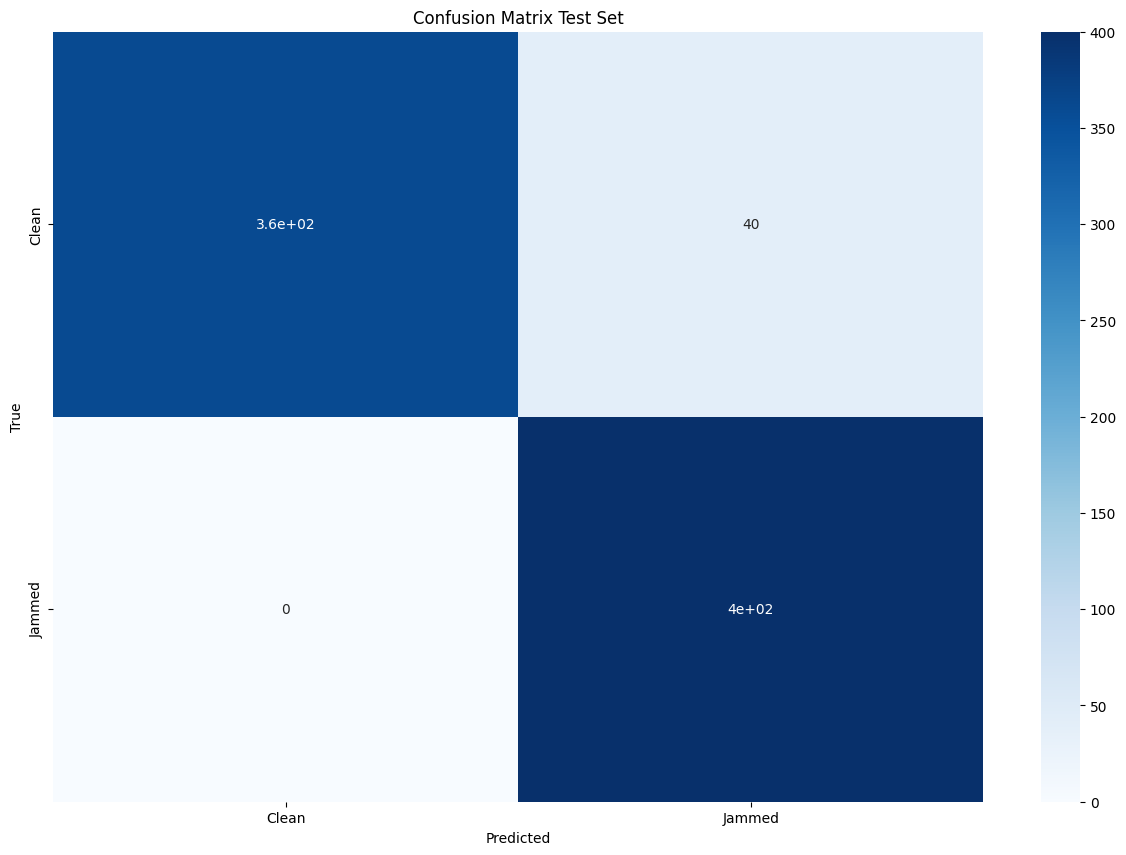

In [29]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold